In [1]:
!pip install transformers

     |████████████████████████████████| 4.2 MB 16.5 MB/s 
     |████████████████████████████████| 6.6 MB 58.6 MB/s 
     |████████████████████████████████| 84 kB 1.0 MB/s 
     |████████████████████████████████| 596 kB 68.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
!git clone https://github.com/gdunlevy/ENLP-Final-Project.git

Cloning into 'ENLP-Final-Project'...
remote: Enumerating objects: 262, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 262 (delta 52), reused 20 (delta 6), pack-reused 155
Receiving objects: 100% (262/262), 1.38 MiB | 1.53 MiB/s, done.
Resolving deltas: 100% (100/100), done.


In [3]:
%cd ENLP-Final-Project/
%ls

/content/ENLP-Final-Project
 hetero_cnn.py        parse_data_trial.py   semeval2017_task7/   visuals.py
 homo_cnn.py          read_gold.py         'subtask 1'/
 parse_data_test.py   README.md            'subtask 2'/


# Subtask 2: Heterographic

In [27]:
import parse_data_test as p
import os

f = 'semeval2017_task7/data/test/subtask2-heterographic-test.xml'

mytree = p.ET.parse(f)
myroot = mytree.getroot()

puns = []
for item in myroot.findall('./text'):
  dict1 = {}
  dict1[item.attrib['id']] = {}
  for child in item:
    idd = child.attrib['id']
    dict1[item.attrib['id']][idd] = child.text
  puns.append(dict1)

print(puns[0])

{'het_1': {'het_1_1': "'", 'het_1_2': "'", 'het_1_3': 'I', 'het_1_4': "'", 'het_1_5': 'm', 'het_1_6': 'halfway', 'het_1_7': 'up', 'het_1_8': 'a', 'het_1_9': 'mountain', 'het_1_10': ',', 'het_1_11': "'", 'het_1_12': "'", 'het_1_13': 'Tom', 'het_1_14': 'alleged', 'het_1_15': '.'}}


In [28]:
gold = []
with open('/content/ENLP-Final-Project/semeval2017_task7/data/test/subtask2-heterographic-test.gold', 'r') as fin:
  for row in fin:
    gold.append(row.strip().split('\t')[1])
print(gold[:5])

['het_1_14', 'het_2_13', 'het_4_11', 'het_5_5', 'het_7_6']


In [6]:
from sklearn.metrics import accuracy_score

In [45]:
def check(l, l2, puns, gold):
  found = 0
  for i, j in enumerate(puns):
    for pun in j.values():
      s = min(len(pun) - 1, int(l * len(pun)))
      s2 = min(len(pun) - 1, int(l2 * len(pun)))
      for k, x in enumerate(pun):
        if x == gold[i] and k >= s and k < s2:
          found += 1
  return found

## BERT

In [55]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch

device = "cuda:0" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModelForMaskedLM.from_pretrained("bert-base-uncased", output_hidden_states=True).to(device)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [57]:
import torch
import copy
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

m = torch.nn.Softmax(dim=0)

def bert(puns, gold, ratio=0, ordered=False):
  res = []
  position = 0

  for i in tqdm(puns):
    for pun in i.values():
      poss = [x for x in pun]
      sent = ' '.join([pun[x] for x in pun])
      toks = []
      s = False
      for x in pun:
        subwords = tokenizer.tokenize((' ' if s else '') + pun[x])
        s = True
        for pos, t in enumerate(subwords):
          toks.append([t, pos])

      tok = tokenizer(sent, return_tensors="pt").to(device)
      old = copy.deepcopy(tok['input_ids'][0])
      # hidden = out.hidden_states[0].cpu().detach().numpy().tolist()[0]
      # print(len(hidden))
      # print(hidden)
      probs = []
      l = len(tok['input_ids'][0])
      # for k in range(1, l - 1):
      for k in range(l - 2, 0, -1):
        # print(toks[k - 1])
        tok['input_ids'][0][k] = torch.tensor(103)

        out = model(**tok)
        token_logits = out.logits
        masked_logits = m(token_logits[0, k, :])
        maxi = torch.argmax(masked_logits)
        maximum = [tokenizer.decode(maxi), masked_logits[maxi].item()]
        probs.append([tokenizer.decode([old[k]]), masked_logits[old[k]].item()])
        # print(tokenizer.decode(tok['input_ids'][0]))
        # print(tokenizer.decode([old[k]]), probs[-1], maximum)
        if toks[k - 1][1] == 0:
          tok['input_ids'][0] = copy.deepcopy(old)
      probs = list(reversed(probs))
      mult_scores = []
      cur, cur_str = 1, ''
      pos = 0
      l = len(probs)
      for i in range(l):
        if toks[i][1] == 0:
          mult_scores.append([cur, cur_str, pos])
          pos += 1
          cur = 1
          cur_str = ''
        cur *= probs[i][1]
        cur_str += probs[i][0]
      mult_scores.append([cur, cur_str, pos])

      mini = mult_scores[0]
      l = len(mult_scores)
      s = min(l - 1, int(ratio * l))
      print(sent)
      print(sorted(mult_scores[s:]))
      if not ordered:
        for i in range(s, l):
          if mult_scores[i][0] < mini[0]:
            mini = mult_scores[i]
        res.append(poss[mini[2] - 1])
      else:
        mult_scores = mult_scores[s:]
        mult_scores.sort()
        ans = max([x[2] for x in mult_scores[:ordered]])
        res.append(poss[ans - 1])
    position += 1
    
  return res

In [60]:
bert(puns[30:60], gold[30:69], 0.6)

  3%|▎         | 1/30 [00:00<00:04,  6.32it/s]

His wife left him saying she was going home to mutter .
[[4.675368927564705e-07, 'mutter', 11], [0.19446393847465515, 'home', 9], [0.5882024168968201, 'going', 8], [0.8704280853271484, 'to', 10], [0.9781174063682556, '.', 12], [0.9936311841011047, 'was', 7]]


  7%|▋         | 2/30 [00:00<00:05,  5.00it/s]

Yesterday a cow saved my life - it was bovine intervention .
[[1.971264843995176e-06, 'bo##vine', 10], [0.0006804117001593113, 'intervention', 11], [0.0220498014241457, '-', 7], [0.7927283644676208, 'it', 8], [0.9013113975524902, 'was', 9], [0.9495028257369995, '.', 12]]


 10%|█         | 3/30 [00:00<00:07,  3.64it/s]

' ' Why is this telephone flex always tangled ? ' ' asked Tom coyly .
[[2.636964643501531e-08, 'co##yl##y', 15], [0.0031353593803942204, 'tom', 14], [0.08038966357707977, "'", 12], [0.09472128003835678, 'asked', 13], [0.9810108542442322, "'", 11], [0.9967063069343567, '.', 16], [0.9983185529708862, '?', 10]]


 13%|█▎        | 4/30 [00:01<00:06,  3.74it/s]

Fashion is something that goes in one era and out the other .
[[1.4799419659539126e-05, 'era', 8], [0.08924373984336853, 'out', 10], [0.7871729731559753, 'other', 12], [0.8504461646080017, 'and', 9], [0.9735782146453857, '.', 13], [0.9761747121810913, 'the', 11]]


 17%|█▋        | 5/30 [00:01<00:06,  3.85it/s]

What kind of flooring do alligator hunters use ? Reptiles !
[[7.312372417800361e-06, 'reptiles', 10], [0.00016763736493885517, 'hunters', 7], [0.02317529357969761, '!', 11], [0.23698340356349945, '?', 9], [0.42210009694099426, 'use', 8]]


 20%|██        | 6/30 [00:01<00:06,  3.97it/s]

The ultimate liquid measure is the supreme quart .
[[8.872352618629017e-07, 'qu##art', 8], [7.66137964092195e-05, 'supreme', 7], [0.9344142079353333, '.', 9], [0.9502158164978027, 'the', 6]]


 23%|██▎       | 7/30 [00:01<00:06,  3.62it/s]

When his clothes dryer broke he was lint another one .
[[2.6188640670287494e-09, 'lin##t', 8], [0.00029532474582083523, 'another', 9], [0.0032290222588926554, 'one', 10], [0.006846782751381397, 'was', 7], [0.9684721827507019, '.', 11]]


 27%|██▋       | 8/30 [00:02<00:06,  3.42it/s]

Acupuncture is a jab well done .
[[8.388610127456195e-07, 'ja##b', 4], [0.03903701528906822, 'done', 6], [0.07096128165721893, 'well', 5], [0.9456385970115662, '.', 7]]


 30%|███       | 9/30 [00:02<00:06,  3.36it/s]

Cows make noise only when they ' re in the mood .
[[0.002528856508433819, 'mood', 11], [0.29325801134109497, 'the', 10], [0.9438340067863464, '.', 12], [0.9997138381004333, 'in', 9], [0.9999819993972778, "'", 7], [0.9999916553497314, 're', 8]]


 37%|███▋      | 11/30 [00:03<00:06,  2.93it/s]

When asked by a Health Department official to describe the mess he saw on the slaughterhouse floor , the USDA inspector replied , ' ' It was just offal . ' '
[[6.274905770063878e-10, 'off##al', 29], [2.286181559970642e-07, 'usd##a', 20], [0.0006246356060728431, "'", 32], [0.01333756372332573, 'inspector', 21], [0.014068438671529293, 'just', 28], [0.6529920101165771, 'replied', 22], [0.8374834656715393, ',', 23], [0.8597509264945984, "'", 31], [0.8624351024627686, 'the', 19], [0.8661785125732422, 'it', 26], [0.9527291655540466, 'was', 27], [0.9654675722122192, '.', 30], [0.97982257604599, "'", 24], [0.9912799000740051, "'", 25]]
After burning a batch of cookies a baker felt very crummy .
[[2.7295205473258117e-07, 'cr##um##my', 11], [0.0008474524365738034, 'baker', 8], [0.02094191126525402, 'a', 7], [0.02333664335310459, 'felt', 9], [0.17961934208869934, 'very', 10], [0.9684260487556458, '.', 12]]


 43%|████▎     | 13/30 [00:03<00:04,  3.98it/s]

The boating store had its best sail ever .
[[2.4846802261890844e-05, 'sail', 7], [0.0003004478057846427, 'ever', 8], [0.1669130176305771, 'best', 6], [0.9557511806488037, '.', 9]]
When asked to picture the perfect modern defensive weapon the Claymore springs to mine .
[[8.717659625290253e-07, 'springs', 12], [7.49610944694723e-06, 'mine', 14], [1.1412792132734276e-05, 'clay##more', 11], [0.003476493526250124, 'to', 13], [0.024838263168931007, 'weapon', 9], [0.20683243870735168, 'the', 10], [0.9772551655769348, '.', 15]]


 47%|████▋     | 14/30 [00:03<00:03,  4.39it/s]

When it got stuck in the mud my car had to be toad .
[[3.388337077581127e-08, 'toad', 13], [0.007101994939148426, 'car', 9], [0.07863681763410568, 'had', 10], [0.09958834946155548, 'be', 12], [0.9331450462341309, '.', 14], [0.9982307553291321, 'to', 11]]


 50%|█████     | 15/30 [00:04<00:03,  4.18it/s]

When my camera fell in the toffee I was making , I got a very candied picture .
[[1.2232076897692252e-08, 'candi##ed', 16], [0.043691132217645645, 'picture', 17], [0.10059084743261337, 'very', 15], [0.22345691919326782, 'got', 13], [0.9552615284919739, 'i', 12], [0.9869115352630615, '.', 18], [0.9902985692024231, 'a', 14], [0.9928345680236816, ',', 11]]


 53%|█████▎    | 16/30 [00:04<00:03,  4.04it/s]

She wanted the large estate quite badly but , she dared not mansion it to her frugal husband .
[[3.853710794052561e-09, 'fr##uga##l', 17], [1.491616785642691e-06, 'mansion', 13], [0.09070862829685211, 'to', 15], [0.1484897881746292, 'husband', 18], [0.8110877871513367, 'not', 12], [0.8503507971763611, 'it', 14], [0.9797781705856323, '.', 19], [0.9851757287979126, 'her', 16]]


 57%|█████▋    | 17/30 [00:04<00:03,  4.08it/s]

' ' I ' ve been listening to the Brandenburg Concertos , ' ' Tom barked .
[[8.345889909833204e-06, 'barked', 16], [0.00030734908068552613, 'tom', 15], [0.0004922270696683384, 'concerto##s', 11], [0.0014234447153285146, 'brandenburg', 10], [0.6109957695007324, ',', 12], [0.9405984878540039, "'", 14], [0.994396448135376, "'", 13], [0.9991089701652527, '.', 17]]


 63%|██████▎   | 19/30 [00:04<00:02,  4.41it/s]

By yourself you ' re in the right . In a group you ' re in the throng .
[[4.316699016208629e-07, 'th##rong', 18], [0.019843125715851784, 'group', 12], [0.7653247117996216, 'the', 17], [0.9101170301437378, 'in', 16], [0.989510715007782, 'you', 13], [0.9970070719718933, '.', 19], [0.999950647354126, 're', 15], [0.9999861717224121, "'", 14]]
When the glassblower inhaled he got a pane in the stomach .
[[7.59617627801023e-08, 'pan##e', 8], [9.06203713384457e-05, 'stomach', 11], [0.16969649493694305, 'the', 10], [0.6226952075958252, 'in', 9], [0.8721649646759033, 'a', 7], [0.9773014187812805, '.', 12]]


 67%|██████▋   | 20/30 [00:05<00:02,  4.85it/s]

If gophers become extinct , the hole ecosystem will die .
[[5.686203621735331e-06, 'hole', 7], [0.011210475116968155, 'ecosystem', 8], [0.054011959582567215, 'die', 10], [0.7706651091575623, 'will', 9], [0.964472234249115, '.', 11]]


 70%|███████   | 21/30 [00:05<00:01,  4.86it/s]

' ' I can see through the window , ' ' said Tom stiltedly .
[[7.741557751552699e-08, 'stil##ted##ly', 14], [0.003967604134231806, 'tom', 13], [0.646246612071991, 'said', 12], [0.8012872338294983, ',', 9], [0.9861115217208862, "'", 10], [0.9980851411819458, '.', 15], [0.9985124468803406, "'", 11]]


 77%|███████▋  | 23/30 [00:05<00:01,  4.28it/s]

When I went to the International Club , I accidentally spilled coffee on a Hindu lady ' s dress . I told her I was very sari .
[[2.425539407160192e-07, 'sar##i', 27], [1.782008803274948e-05, 'very', 26], [0.005221983417868614, 'dress', 19], [0.06487135589122772, 'i', 24], [0.5596837401390076, 'was', 25], [0.8037623763084412, '.', 20], [0.9313896894454956, 'her', 23], [0.9783918857574463, '.', 28], [0.9807699918746948, 'told', 22], [0.9956222176551819, 'i', 21], [0.9999024868011475, "'", 17], [0.9999912977218628, 's', 18]]
The Net - surfing bandits always ended an operation by clearing out the cash .
[[0.00022320201969705522, 'cash', 14], [0.0016857757000252604, 'clearing', 11], [0.005070738960057497, 'operation', 9], [0.44038820266723633, 'out', 12], [0.6569916605949402, 'by', 10], [0.7192165851593018, 'the', 13], [0.9809020757675171, '.', 15]]


 83%|████████▎ | 25/30 [00:06<00:00,  5.16it/s]

Leftover spaghetti is pasta its prime .
[[4.0458836281231925e-08, 'pasta', 4], [0.00010927506082225591, 'prime', 6], [0.00021836503583472222, 'its', 5], [0.926741361618042, '.', 7]]
' ' This food tastes of plutonium , ' ' said Tom glowingly .
[[1.1086812083811162e-06, 'glowing##ly', 13], [0.00040912910480983555, 'tom', 12], [0.2718500792980194, 'said', 11], [0.9896313548088074, "'", 9], [0.9985051155090332, '.', 14], [0.9986209869384766, "'", 10]]


 87%|████████▋ | 26/30 [00:06<00:00,  5.08it/s]

' ' Would you like some soda ? ' ' asked Tom caustically .
[[8.39771484224254e-11, 'ca##ust##ically', 13], [0.009048553183674812, 'tom', 12], [0.1701367348432541, 'asked', 11], [0.4673856794834137, "'", 10], [0.9903609752655029, "'", 9], [0.9988659620285034, '.', 14]]


 93%|█████████▎| 28/30 [00:06<00:00,  4.53it/s]

When the florist was running behind in delivering the roses , he had to put the petal to the metal .
[[8.52775263710144e-06, 'pet##al', 17], [0.00020271491666790098, 'metal', 20], [0.013780055567622185, 'put', 15], [0.11238104104995728, 'to', 18], [0.4079965054988861, 'had', 13], [0.4570918381214142, 'the', 16], [0.8761674165725708, 'to', 14], [0.9626233577728271, 'the', 19], [0.9884124398231506, '.', 21]]
I just had some coffee that was good only for its sedimental value .
[[4.99222224152277e-09, 'sediment##al', 12], [0.01684677042067051, 'value', 13], [0.032618649303913116, 'only', 9], [0.6680271029472351, 'for', 10], [0.7466282844543457, 'its', 11], [0.9867997169494629, '.', 14]]


100%|██████████| 30/30 [00:07<00:00,  4.17it/s]

Children can do some knotty things with string .
[[4.80288035760168e-05, 'string', 8], [0.19243144989013672, 'things', 6], [0.7796414494514465, 'with', 7], [0.9600937366485596, '.', 9]]
A waterbed may just be the vinyl resting place .
[[4.7050505713741586e-08, 'vinyl', 7], [0.027689410373568535, 'the', 6], [0.09166543930768967, 'resting', 8], [0.6268852949142456, 'place', 9], [0.934209406375885, '.', 10]]


['het_42_11',
 'het_43_10',
 'het_44_15',
 'het_45_8',
 'het_46_10',
 'het_47_8',
 'het_49_8',
 'het_50_4',
 'het_51_11',
 'het_54_29',
 'het_55_11',
 'het_56_7',
 'het_58_12',
 'het_59_13',
 'het_60_16',
 'het_62_17',
 'het_64_16',
 'het_65_18',
 'het_66_8',
 'het_67_7',
 'het_69_14',
 'het_70_27',
 'het_71_14',
 'het_72_4',
 'het_73_13',
 'het_74_13',
 'het_75_17',
 'het_76_12',
 'het_77_8',
 'het_78_7']

In [68]:
for ratio in [0.0, 0.5]:
  print(ratio, accuracy_score(gold, bert(puns, gold, ratio)))

100%|██████████| 1271/1271 [04:09<00:00,  5.10it/s]


0.0 0.6734854445318647


100%|██████████| 1271/1271 [04:04<00:00,  5.20it/s]

0.5 0.8040912667191188


In [69]:
for ratio in [0.6, 0.7, 0.8]:
  print(ratio, accuracy_score(gold, bert(puns, gold, ratio)))

100%|██████████| 1271/1271 [04:03<00:00,  5.21it/s]


0.6 0.8229740361919748


100%|██████████| 1271/1271 [04:03<00:00,  5.22it/s]


0.7 0.8111723052714398


100%|██████████| 1271/1271 [04:02<00:00,  5.24it/s]

0.8 0.7254130605822188


In [ ]:
import torch
import copy
from tqdm import tqdm
m = torch.nn.Softmax(dim=0)

res = []

for i in tqdm(puns):
  for pun in i.values():
    poss = [x for x in pun]
    sent = ' '.join([pun[x] for x in pun])
    tok = tokenizer(sent, return_tensors="pt").to(device)
    orig = copy.deepcopy(tok)
    probs = []
    l = len(tok['input_ids'][0])
    for i in range(1, l - 1):
      old = copy.deepcopy(tok['input_ids'][0][i])
      tok['input_ids'][0][i] = torch.tensor(103)
      # print(tokenizer.decode(tok['input_ids'][0]))

      token_logits = model(**tok).logits
      masked_logits = m(token_logits[0, i, :])

      # maximum = masked_logits[torch.argmax(masked_logits)].item()

      probs.append(masked_logits[old].item())
      # print(tokenizer.decode([old]), probs[-1])
      tok = copy.deepcopy(orig)

    toks = tokenizer.tokenize(sent, return_tensors="pt")
    toks.append('')
    min_score, min_pos = 2, poss[0]
    cur = 1
    pos = -1
    l = len(probs)
    for i in range(min(l // 2, l - 1), l):
      # print(tok[i], probs[i])
      if not toks[i].startswith('##'):
        if cur < min_score and i >= l // 2:
          min_score = cur
          min_pos = pos
        pos += 1
        cur = 1
      cur *= probs[i]
    print(sent, pun[poss[min_pos]])
    res.append(poss[min_pos])

  0%|          | 1/1271 [00:00<08:11,  2.58it/s]

' ' I ' m halfway up a mountain , ' ' Tom alleged . alleged


  0%|          | 2/1271 [00:00<09:01,  2.34it/s]

I ' d like to be a Chinese laborer , said Tom coolly . Chinese


  0%|          | 4/1271 [00:01<05:57,  3.55it/s]

Dentists don ' t like a hard day at the orifice . day
Are evil wildebeests bad gnus ? gnus


  0%|          | 6/1271 [00:01<04:28,  4.71it/s]

A busy barber is quite harried . quite
My name is Avery . I raise birds . birds


  1%|          | 8/1271 [00:01<03:58,  5.30it/s]

Two construction workers had a stairing contest . stairing
In the winter , some horses are Friesian . horses


  1%|          | 9/1271 [00:02<04:27,  4.71it/s]

It ' s between my sole and my heel , said Tom archly . archly


  1%|          | 10/1271 [00:02<04:37,  4.54it/s]

OLD ELECTRICIANS never die , they just do it until it Hz . Hz


  1%|          | 11/1271 [00:02<06:25,  3.27it/s]

Yesterday I accidentally swallowed some food coloring . The doctor says I ' m OK , but I feel like I ' ve dyed a little inside . dyed
Follow your knows . knows


  1%|          | 14/1271 [00:03<04:35,  4.57it/s]

A china doll was marked in tiny letters : ' maid in USA ' . maid
I deny everything , said Tom knowingly . Tom


  1%|          | 15/1271 [00:03<05:02,  4.15it/s]

The key to changing your performance ability is by tuning out criticism and staying musically octave . octave


  1%|▏         | 16/1271 [00:04<05:40,  3.69it/s]

She was only a Farmer ' s daughter , but she was the best little hoer in the county . hoer


  1%|▏         | 17/1271 [00:04<06:07,  3.41it/s]

' ' I ' ve stuck a pin through my nose , ' ' said Tom punctually . Tom


  1%|▏         | 19/1271 [00:04<05:02,  4.13it/s]

I ' m the presenter of the South Bank Show , Melvyn bragged . bragged
We welcome you with open psalms . psalms


  2%|▏         | 20/1271 [00:05<05:03,  4.13it/s]

Diets are for people who are thick and tired of it all . thick


  2%|▏         | 21/1271 [00:05<05:01,  4.15it/s]

When Socrates needed to buy food he went to the grocery stoa . stoa


  2%|▏         | 22/1271 [00:05<05:10,  4.03it/s]

The cobbler was asked how many shoes he had soled by a well by


  2%|▏         | 23/1271 [00:05<05:21,  3.89it/s]

They won ' t stay at friendly hotels , because they ' re hostel people . hostel


  2%|▏         | 24/1271 [00:06<06:26,  3.22it/s]

Let ' s all play an A , a C sharp , and an E , cried Tom ' s band with one accord . cried


  2%|▏         | 25/1271 [00:06<06:48,  3.05it/s]

The young pine sapling was admonished by his father . Apparently he ' d been knotty . knotty


  2%|▏         | 26/1271 [00:06<06:27,  3.21it/s]

The doctors had to remove a bone from my arm , said Tom humorlessly . Tom


  2%|▏         | 27/1271 [00:07<06:38,  3.12it/s]

I ' ve been to a film festival in the South of France , said Tom cannily . cannily


  2%|▏         | 28/1271 [00:07<06:16,  3.30it/s]

A music store was robbed . The thief made away with the lute . made


  2%|▏         | 29/1271 [00:07<06:32,  3.16it/s]

He threw jello at his wife , who had him arrested for carrying a congealed weapon . him


  2%|▏         | 30/1271 [00:08<06:56,  2.98it/s]

' ' Be still my hart ' ' she murmured , thinking how magnificent and stag - like he was . magnificent


  2%|▏         | 31/1271 [00:08<06:08,  3.37it/s]

His wife left him saying she was going home to mutter . mutter


  3%|▎         | 32/1271 [00:08<05:40,  3.64it/s]

Yesterday a cow saved my life - it was bovine intervention . intervention


  3%|▎         | 33/1271 [00:09<05:53,  3.51it/s]

' ' Why is this telephone flex always tangled ? ' ' asked Tom coyly . tangled


  3%|▎         | 34/1271 [00:09<05:30,  3.75it/s]

Fashion is something that goes in one era and out the other . era


  3%|▎         | 36/1271 [00:09<04:39,  4.42it/s]

What kind of flooring do alligator hunters use ? Reptiles ! Reptiles
The ultimate liquid measure is the supreme quart . supreme


  3%|▎         | 38/1271 [00:10<04:26,  4.62it/s]

When his clothes dryer broke he was lint another one . lint
Acupuncture is a jab well done . jab


  3%|▎         | 39/1271 [00:10<04:24,  4.66it/s]

Cows make noise only when they ' re in the mood . mood


  3%|▎         | 40/1271 [00:10<07:11,  2.86it/s]

When asked by a Health Department official to describe the mess he saw on the slaughterhouse floor , the USDA inspector replied , ' ' It was just offal . ' ' offal


  3%|▎         | 42/1271 [00:11<05:29,  3.73it/s]

After burning a batch of cookies a baker felt very crummy . baker
The boating store had its best sail ever . sail


  3%|▎         | 43/1271 [00:11<05:36,  3.64it/s]

When asked to picture the perfect modern defensive weapon the Claymore springs to mine . springs


  3%|▎         | 44/1271 [00:11<05:27,  3.75it/s]

When it got stuck in the mud my car had to be toad . toad


  4%|▎         | 45/1271 [00:12<06:01,  3.39it/s]

When my camera fell in the toffee I was making , I got a very candied picture . candied


  4%|▎         | 46/1271 [00:12<06:23,  3.20it/s]

She wanted the large estate quite badly but , she dared not mansion it to her frugal husband . mansion


  4%|▎         | 47/1271 [00:12<06:24,  3.18it/s]

' ' I ' ve been listening to the Brandenburg Concertos , ' ' Tom barked . barked


  4%|▍         | 48/1271 [00:13<06:42,  3.04it/s]

By yourself you ' re in the right . In a group you ' re in the throng . group


  4%|▍         | 49/1271 [00:13<06:15,  3.25it/s]

When the glassblower inhaled he got a pane in the stomach . pane


  4%|▍         | 50/1271 [00:13<05:46,  3.52it/s]

If gophers become extinct , the hole ecosystem will die . hole


  4%|▍         | 51/1271 [00:14<05:49,  3.49it/s]

' ' I can see through the window , ' ' said Tom stiltedly . Tom


  4%|▍         | 52/1271 [00:14<07:10,  2.83it/s]

When I went to the International Club , I accidentally spilled coffee on a Hindu lady ' s dress . I told her I was very sari . very


  4%|▍         | 54/1271 [00:14<05:29,  3.69it/s]

The Net - surfing bandits always ended an operation by clearing out the cash . cash
Leftover spaghetti is pasta its prime . pasta


  4%|▍         | 55/1271 [00:15<05:32,  3.65it/s]

' ' This food tastes of plutonium , ' ' said Tom glowingly . glowingly


  4%|▍         | 56/1271 [00:15<05:35,  3.62it/s]

' ' Would you like some soda ? ' ' asked Tom caustically . Tom


  4%|▍         | 57/1271 [00:15<06:28,  3.13it/s]

When the florist was running behind in delivering the roses , he had to put the petal to the metal . metal


  5%|▍         | 59/1271 [00:16<05:18,  3.80it/s]

I just had some coffee that was good only for its sedimental value . sedimental
Children can do some knotty things with string . string


  5%|▍         | 60/1271 [00:16<04:53,  4.13it/s]

A waterbed may just be the vinyl resting place . vinyl


  5%|▍         | 61/1271 [00:16<05:18,  3.79it/s]

Camille relocated to Little Italy : They made her a cougher ; she couldn ' t refuse cougher


  5%|▍         | 62/1271 [00:17<05:11,  3.88it/s]

A cross between a puppy and a bunny is a rabid dog . bunny


  5%|▍         | 63/1271 [00:17<04:53,  4.12it/s]

I ' m a lion hunter , said Tom , pridefully Tom


  5%|▌         | 64/1271 [00:17<05:11,  3.88it/s]

The sign on the nudist camp said , ' Clothed ' til May ' . Clothed


  5%|▌         | 65/1271 [00:17<05:07,  3.92it/s]

To kill a circus in one blow , go for the juggler . go


  5%|▌         | 67/1271 [00:18<04:32,  4.41it/s]

I ' m from a Humberside port , said Tom ghoulishly . port
I love cats , Tom mused . mused


  5%|▌         | 69/1271 [00:18<04:12,  4.76it/s]

OLD BUTCHERS never die , they only meat their fate . meat
The inventor of chewing gum soon bubbled his money . soon


  6%|▌         | 71/1271 [00:19<04:50,  4.12it/s]

A young corporal dislocated his arm during a battle but kept going . You could say he was shouldering on . shouldering
The manufacturing of t - shirts has really cotton . cotton


  6%|▌         | 72/1271 [00:19<04:39,  4.29it/s]

My name is Matt . I ' m a doorman . doorman


  6%|▌         | 74/1271 [00:19<04:30,  4.43it/s]

When the crop was destroyed , there was no more cranberry source . source
I phoned the zoo but the lion was busy . lion


  6%|▌         | 76/1271 [00:20<04:19,  4.60it/s]

' ' Boy , that ' s a bright star , ' ' said Tom seriously . seriously
The postmen get together for mail bonding . bonding


  6%|▌         | 78/1271 [00:20<03:42,  5.35it/s]

Authors can be very PENsive . PENsive
My name is Harry . I ' m a barber . barber


  6%|▋         | 80/1271 [00:21<04:02,  4.91it/s]

Neuter your dog - an ounce of prevention is better than a pound of curs . prevention
Giving praise is when you let off esteem . esteem


  6%|▋         | 82/1271 [00:21<04:07,  4.81it/s]

' ' Now I can do some painting , ' ' said Tom easily . easily
People who like gold paint have a gilt complex . complex


  7%|▋         | 83/1271 [00:21<04:50,  4.09it/s]

The bald man decided to consider a hair transplant to rogaine his confidence in looking younger . rogaine


  7%|▋         | 84/1271 [00:22<05:54,  3.35it/s]

The self - conscious shipbuilder tried to recruit extremely sycophantic sailors to compliment her newly designed destroyer . extremely


  7%|▋         | 85/1271 [00:22<05:21,  3.68it/s]

The obese editor started a weight redaction program . weight


  7%|▋         | 87/1271 [00:23<06:25,  3.07it/s]

An optometrist told his patient : ' It appears your vision is improving ! ' ' Really ? ' replied the patient . ' Must be the luck of the iris . ' iris
In the dark ? Follow the son . son


  7%|▋         | 89/1271 [00:23<05:11,  3.79it/s]

As to how to play snooker , some people don ' t have a cue . cue
A parade of horses went down Mane street . Mane


  7%|▋         | 90/1271 [00:24<05:31,  3.57it/s]

I used to do rock climbing as a youth , but I was much boulder back then . boulder


  7%|▋         | 92/1271 [00:24<04:57,  3.96it/s]

Dateline London : Eccentric ornithologist travels to foreign land to teach pigeon English . pigeon
Some childen are often on their pest behavior . pest


  7%|▋         | 93/1271 [00:25<08:33,  2.29it/s]

When gossip finally led to the landlady ' s arrest for murdering her tenants and scattering parts of their bodies around town , her only comment was , ' ' Well , that ' s what comes of spreading roomers . ' ' roomers


  7%|▋         | 94/1271 [00:25<07:23,  2.65it/s]

I ' ll never give up my hounds ! Tom said doggedly . hounds


  8%|▊         | 96/1271 [00:26<06:10,  3.17it/s]

Someone once accused me of stealing an old , rare , valuable stamp , and I philately denied it . denied
To learn rope tricks you have to be taut . taut


  8%|▊         | 97/1271 [00:26<06:00,  3.26it/s]

For the woman who wore size 13 , finding shoes that fit was no small feat . shoes


  8%|▊         | 98/1271 [00:27<07:39,  2.55it/s]

Wife to husband , ' ' That was an explosive passage of gas , I ' d say about 8 . 0 on the sphincter scale . ' ' scale


  8%|▊         | 99/1271 [00:27<08:59,  2.17it/s]

When I phoned my friend yesterday we mainly talked about the weather and our upcomimg exams , and we both agreed that the poring was sickening . upcomimg


  8%|▊         | 100/1271 [00:28<08:21,  2.33it/s]

Have you ever read the Rime of the Ancient Gardener ? It was written by Samuel Taylor Foliage . Foliage


  8%|▊         | 102/1271 [00:28<06:22,  3.06it/s]

It ' s amazing what two or more sinners can achieve together with synergy . sinners
Some mathematicians are reluctant to cosine a loan . loan


  8%|▊         | 103/1271 [00:28<05:58,  3.26it/s]

' ' We have no oranges , ' ' Tom said fruitlessly . oranges


  8%|▊         | 104/1271 [00:29<06:15,  3.10it/s]

I dropped a tub of margarine in the kitchen and ended up with a Parkay floor . Parkay


  8%|▊         | 105/1271 [00:29<05:46,  3.36it/s]

A drummer can cymbalize the enthusiasm of a band . enthusiasm


  8%|▊         | 107/1271 [00:29<04:48,  4.04it/s]

' ' I have to keep this fire alight , ' ' Tom bellowed . bellowed
A cook made pancakes flippantly . pancakes


  9%|▊         | 109/1271 [00:30<04:12,  4.60it/s]

Nice looking glass ! said Tom reflectively . reflectively
What keeps a dock floating above water ? Pier pressure . Pier


  9%|▊         | 110/1271 [00:30<04:28,  4.33it/s]

Legends tell us that a weakness of the carnivorous vampire is a steak . steak


  9%|▊         | 111/1271 [00:30<04:59,  3.87it/s]

There ' s nothing to stop me putting things in tins , said Tom cannily . tins


  9%|▉         | 113/1271 [00:31<04:00,  4.81it/s]

The pistol of a flower is its only protections against insects . protections
Psychiatrists like Kentucky Freud Chicken . Freud


  9%|▉         | 114/1271 [00:31<03:49,  5.04it/s]

I hate sweet potatoes , Tom yammered . Tom


  9%|▉         | 116/1271 [00:31<03:50,  5.02it/s]

The workers at that inn are very unfriendly . They create a hostel environment . hostel
Hotel owners usually have suite dreams . suite


  9%|▉         | 117/1271 [00:32<04:56,  3.89it/s]

The telemarketer asked me if I read magazines at all and I replied that I did , periodically . periodically


  9%|▉         | 118/1271 [00:32<06:49,  2.82it/s]

When the proposal was made to locate the governor ' s mansion in Albany , New Yorkers said , ' ' That ' s a capitol idea . ' ' capitol


  9%|▉         | 119/1271 [00:32<06:01,  3.19it/s]

She became an art dealer because she wanted more Monet . Monet


 10%|▉         | 121/1271 [00:33<05:22,  3.56it/s]

The corner of Ninth and Broad attracts a lot of the homeless because of its reputation for having a grate area for sleeping homeless
7 days without prayer makes 1 weak makes


 10%|▉         | 122/1271 [00:33<04:34,  4.18it/s]

You should never take rocks for granite . granite


 10%|▉         | 123/1271 [00:33<05:00,  3.82it/s]

' ' If I let go of the ceiling it will collapse , ' ' Tom upheld . upheld


 10%|▉         | 124/1271 [00:34<05:54,  3.24it/s]

' ' For what we are about to receive , may the Lord make us truly thankful , ' ' said Tom gracefully . gracefully


 10%|▉         | 125/1271 [00:34<06:06,  3.13it/s]

Before the golfer finished drinking the iced , brewed beverage he dropped his tee on the cart path . path


 10%|▉         | 126/1271 [00:34<05:29,  3.47it/s]

He avoided funerals because he was not a mourning person . mourning


 10%|▉         | 127/1271 [00:35<05:17,  3.61it/s]

They say curiosity killed the cat , and they weren ' t kitten . kitten


 10%|█         | 128/1271 [00:35<05:51,  3.25it/s]

During a recent trip to Qatar , Bill Clinton went to McDonald ' s and ordered fries with a sheik . fries


 10%|█         | 129/1271 [00:35<05:57,  3.19it/s]

' ' I swallowed some of the glass from that broken window , ' ' Tom said painfully . Tom


 10%|█         | 130/1271 [00:36<06:07,  3.11it/s]

A farmer wanting to kill a chicken for dinner has to move faster than a speeding pullet . pullet


 10%|█         | 131/1271 [00:36<05:39,  3.36it/s]

OLD CHEMISTS never die , they just lose their refluxes . refluxes


 10%|█         | 132/1271 [00:36<06:13,  3.05it/s]

' ' I chop down trees for a living , ' ' said Tom lumberingly . lumberingly


 11%|█         | 134/1271 [00:37<05:34,  3.40it/s]

There is nothing worse for a performer than an audience of drunks and their boos . boos
Truckers like houses with long haulways . haulways


 11%|█         | 135/1271 [00:37<06:13,  3.04it/s]

' ' The sun is rising , ' ' Tom mourned . Tom


 11%|█         | 137/1271 [00:38<05:07,  3.69it/s]

A politician who had been an astronomer was always saying ' no comet ' . astronomer
Come in and get a peace of the rock peace


 11%|█         | 139/1271 [00:39<05:31,  3.42it/s]

' ' I know what herb would taste nice with this , ' ' said Tom sagely . nice
An heir is someone with a descent wage . wage


 11%|█         | 141/1271 [00:39<04:37,  4.07it/s]

The shy stripper couldn ' t bare it on stage . bare
Those who have icicles keep a stiff upper drip . drip


 11%|█         | 142/1271 [00:39<04:47,  3.93it/s]

I learned that the antelopes were coming when I heard the gnus . gnus


 11%|█▏        | 143/1271 [00:40<05:26,  3.45it/s]

A paramedic got a new job as a chauffeur : an ambiance driver . :


 11%|█▏        | 144/1271 [00:40<05:01,  3.73it/s]

Two cheerleaders got married after they met by chants . chants


 11%|█▏        | 146/1271 [00:40<04:44,  3.95it/s]

After the sniper attack at the symphony softball game , there were no men left on bass . bass
OLD CHINESE COOKS never die , they just wok away wok


 12%|█▏        | 147/1271 [00:40<04:19,  4.34it/s]

My name is Manuel , I write instruction books . instruction


 12%|█▏        | 148/1271 [00:41<04:16,  4.38it/s]

The ailing king of the doves sensed an imminent coup . doves


 12%|█▏        | 150/1271 [00:41<04:07,  4.53it/s]

OLD SAILORS never die , they just lose their porpoise . just
OLD ANTENNA ENGINEERS never die , they just phase away . phase


 12%|█▏        | 151/1271 [00:41<04:11,  4.45it/s]

If you ride a bus you have to pay your fare share . share


 12%|█▏        | 152/1271 [00:42<04:26,  4.19it/s]

If you work in a bakery you may have to take on many roles . many


 12%|█▏        | 154/1271 [00:42<05:25,  3.43it/s]

My wife uses a kitchen implement to shred garlic and parmesan cheese , which I hate . It really is the grater of two evils . grater
Chickens can give some people a foul rash . foul


 12%|█▏        | 155/1271 [00:43<05:01,  3.70it/s]

Everybody was in shock when the hair stylist dyed . dyed


 12%|█▏        | 156/1271 [00:43<05:05,  3.64it/s]

Qwertyus , god of keyboards , is a character from geek mythology . geek


 12%|█▏        | 158/1271 [00:43<04:17,  4.32it/s]

' ' Are you homosexual ? ' ' Tom queried gaily . Tom
Businesses selling pleasure boats often have a sail . sail


 13%|█▎        | 160/1271 [00:44<04:01,  4.60it/s]

Wheaties near the body suggested that police look for a cereal killer . cereal
OLD DOCTORS never die they just lose their patience . patience


 13%|█▎        | 161/1271 [00:44<04:12,  4.40it/s]

The thief broke into the music store and stole the lute . store


 13%|█▎        | 163/1271 [00:44<03:49,  4.83it/s]

The actors had one great movie after another . They were on a role . role
A perfectly spherical pumpkin makes good pi . pi


 13%|█▎        | 165/1271 [00:45<03:28,  5.31it/s]

The invisible cows were herd but not seen . herd
Photography developers occasionally have serious emulsional problems . emulsional


 13%|█▎        | 166/1271 [00:45<04:00,  4.59it/s]

The overweight fighter pilot was grounded for violating the rules of engorgement . engorgement


 13%|█▎        | 167/1271 [00:45<03:57,  4.65it/s]

This is what I have learned off by heart Tom wrote . off


 13%|█▎        | 168/1271 [00:46<05:13,  3.52it/s]

In his free time , my son in college hunts deer and sells the meat . He says the doe helps him with his expenses . doe


 13%|█▎        | 169/1271 [00:46<05:12,  3.53it/s]

' ' 3 . 14159265 , ' ' Tom said piously . 14159265


 13%|█▎        | 170/1271 [00:46<05:09,  3.55it/s]

The geologist went to the doctor because he had a loss of apatite . apatite


 13%|█▎        | 171/1271 [00:46<04:58,  3.69it/s]

OLD GRAVEDIGGERS ; never die , they just spade away . spade


 14%|█▎        | 172/1271 [00:47<05:34,  3.29it/s]

The pun in the title of the play ' ' The Importance of Being Earnest ' ' was a Wilde idea . Wilde


 14%|█▎        | 173/1271 [00:47<05:26,  3.36it/s]

' ' I prefer trout to salmon , ' ' Tom said officiously . Tom


 14%|█▎        | 174/1271 [00:48<06:14,  2.93it/s]

One gruelingly intense month into the year - long diet regimen , the overwhelmed patient concluded she could not stand the weight . overwhelmed


 14%|█▍        | 175/1271 [00:48<05:47,  3.16it/s]

The Vatican ' s supplier of duck eggs is elected by sacred balut . balut


 14%|█▍        | 176/1271 [00:48<05:31,  3.30it/s]

I ' ve been listening to the Brandenberg Concertos , Tom barked . Brandenberg


 14%|█▍        | 177/1271 [00:48<05:06,  3.57it/s]

OLD GOSSIPS never die they just lose their confidants just


 14%|█▍        | 179/1271 [00:49<04:40,  3.89it/s]

When the father found he had septuplets , he could hardly believe his own census . census
Some horses cause their owners a lot of woe . woe


 14%|█▍        | 180/1271 [00:49<06:43,  2.71it/s]

Because the champion angler instructed his pupils to cast their lines where the river runs through narrow chasms , they called him the ' ' fissure King . ' ' narrow


 14%|█▍        | 181/1271 [00:50<05:53,  3.08it/s]

Tried some bear stew . It was a little grizzly . little


 14%|█▍        | 182/1271 [00:50<05:27,  3.33it/s]

The cat in northern Scandinavia always had a lapp to sit on . lapp


 14%|█▍        | 183/1271 [00:50<05:21,  3.39it/s]

Making up puns about the finest soil is the loess form of humor . loess


 14%|█▍        | 184/1271 [00:50<05:01,  3.61it/s]

I haven ' t developed my photographs yet , said Tom negatively . negatively


 15%|█▍        | 185/1271 [00:51<05:05,  3.56it/s]

If you eat soup that ' s nine days old you will get bad broth . bad


 15%|█▍        | 186/1271 [00:51<05:07,  3.52it/s]

' ' This is where I keep my arrows , ' ' said Tom quiveringly . quiveringly


 15%|█▍        | 188/1271 [00:52<04:39,  3.88it/s]

My name is Clarence , I specialize in end - of - season inventory closeout sales . closeout
Herbivores come in browns and graze . browns


 15%|█▍        | 189/1271 [00:52<05:27,  3.30it/s]

A husband who thinks he is as solid as a rock may have a wife who wishes he was a little bolder . may


 15%|█▌        | 191/1271 [00:52<04:33,  3.94it/s]

' ' Congratulations ; you graduated , ' ' said Tom diplomatically . Tom
Are Philosophy papers graded with Marx out of ten ? Marx


 15%|█▌        | 192/1271 [00:53<05:03,  3.56it/s]

The mad scientist in the old castle had a strange secret – but he kept it under his bat . –


 15%|█▌        | 193/1271 [00:53<05:01,  3.57it/s]

A teacher having a tough time longs for the end of the school daze . daze


 15%|█▌        | 195/1271 [00:53<04:13,  4.24it/s]

The Keystone Kops were frequently criticized for excessive use of farce . farce
Scarecrows are always garden their patch . garden


 15%|█▌        | 196/1271 [00:54<03:57,  4.52it/s]

Isn ' t the Grand Canyon just gorges ? just


 15%|█▌        | 197/1271 [00:54<04:02,  4.42it/s]

The church choir robes were too long and needed to be hymned . hymned


 16%|█▌        | 199/1271 [00:54<04:00,  4.46it/s]

' ' Don ' t you know my name ? ' ' asked Tom swiftly . swiftly
Scientists studying the sun have a flare for research . flare


 16%|█▌        | 200/1271 [00:54<03:39,  4.89it/s]

Abstinence makes the heart grow fonder heart


 16%|█▌        | 202/1271 [00:55<04:52,  3.66it/s]

I love your old worn - out jacket covered with all those slogans , but I can ' t read the frays at the end of the sleeves . frays
A clean thief always makes a stainless steal . stainless


 16%|█▌        | 203/1271 [00:56<05:26,  3.27it/s]

' ' Boy , I wish the elevator were working , ' ' said Tom , staring up to the top . staring


 16%|█▌        | 205/1271 [00:56<04:51,  3.66it/s]

The chickens were distraught when the tornado destroyed their home . Hopefully they will be able to recoup . home
Those who hate classical music have my symphony . symphony


 16%|█▌        | 206/1271 [00:56<04:18,  4.12it/s]

The fish were shy - obviously koi . obviously


 16%|█▋        | 207/1271 [00:57<05:04,  3.50it/s]

The Jedi Knight traded in his light saber for a light dagger . He had gone over to the dirk side . dirk


 16%|█▋        | 208/1271 [00:57<04:50,  3.66it/s]

A skunk fell in the river and stank to the bottom . bottom


 16%|█▋        | 209/1271 [00:57<04:29,  3.94it/s]

I fought with Geronimo , said Tom bravely . said


 17%|█▋        | 210/1271 [00:57<04:52,  3.63it/s]

' ' I think I ' ve broken my leg ' ' , reported Tom lamely . reported


 17%|█▋        | 211/1271 [00:58<06:50,  2.58it/s]

We sternly warned the circus clown not to light the fuse while we were inside the cannon , but he did it anyway - - and it really made us soar . soar


 17%|█▋        | 212/1271 [00:58<06:17,  2.81it/s]

' ' I have been reading Voltaire , ' ' Tom admitted candidly . Tom


 17%|█▋        | 213/1271 [00:59<06:04,  2.90it/s]

A doctor ' s mistakes go six feet under ; a dentist ' s cover an acre . acre


 17%|█▋        | 215/1271 [00:59<05:02,  3.49it/s]

A good baker will rise to the occasion , it ' s the yeast he can do . yeast
My sweet mother got so old she granulated . granulated


 17%|█▋        | 217/1271 [01:00<04:36,  3.81it/s]

The vendor at the Arab market resented how I haggled and told me to take a haik . haik
Be the soul supporter of your children . supporter


 17%|█▋        | 218/1271 [01:00<04:19,  4.06it/s]

Some people who cut hair can be quite barbarous . quite


 17%|█▋        | 219/1271 [01:00<04:10,  4.20it/s]

Drinking a whole bucket of water could make you turn pail . turn


 17%|█▋        | 220/1271 [01:00<04:49,  3.63it/s]

She was only a Grape picker ' s daughter , but she was somewhat of a winer . winer


 17%|█▋        | 222/1271 [01:01<04:18,  4.05it/s]

A cat ate some cheese and waited for a mouse with baited breath . baited
Beautifully manicured lawns are highly sod after . sod


 18%|█▊        | 223/1271 [01:01<04:26,  3.93it/s]

The man leaned on the printer cartridge because he wanted to tone up his abs . abs


 18%|█▊        | 225/1271 [01:02<03:43,  4.68it/s]

I ' ll take the girl to the dance , Tom promised . Tom
Two wrongs can make a riot . riot


 18%|█▊        | 226/1271 [01:02<03:32,  4.92it/s]

An illiterate fisherman was lost at c . c


 18%|█▊        | 228/1271 [01:02<03:29,  4.98it/s]

She was so thrifty she could smell a bargain a mall away . mall
Act your praise , not your shoe size . shoe


 18%|█▊        | 229/1271 [01:02<03:21,  5.16it/s]

Partying Saturday and Sunday leaves me feeling weakened . weakened


 18%|█▊        | 230/1271 [01:03<03:52,  4.48it/s]

It was raining cats and dogs . There were poodles all over the road . road


 18%|█▊        | 231/1271 [01:03<04:30,  3.84it/s]

Because they moved into an apartment , they didn ' t need to cut the grass any mow . any


 18%|█▊        | 232/1271 [01:03<04:24,  3.93it/s]

When priests have a good idea they are supposed to parish the thought . parish


 18%|█▊        | 233/1271 [01:03<04:12,  4.11it/s]

The only things sure for cab drivers are debt and taxis . debt


 18%|█▊        | 234/1271 [01:04<05:37,  3.08it/s]

As I revived her using mouth to mouth resuscitation , in spite of my lisp , I couldn ' t help noticing her beautiful breaths ! breaths


 18%|█▊        | 235/1271 [01:04<05:28,  3.16it/s]

Sign at a place where you lose weight : ' Stop Look and Lessen ' . Lessen


 19%|█▊        | 237/1271 [01:05<04:49,  3.57it/s]

She was only a Cyclist ' s daughter , but she peddled it all over town . town
' Because ' is a word to the whys . whys


 19%|█▊        | 238/1271 [01:05<04:48,  3.58it/s]

If you ' re stiff as a board it could be the lumbar . could


 19%|█▉        | 240/1271 [01:05<04:18,  3.99it/s]

A good carpenter will do his work and then varnish without a trace . trace
Geologists can be sedimental about their work . sedimental


 19%|█▉        | 241/1271 [01:06<04:38,  3.70it/s]

If jokes could be owned like land , then no good pun would go undeeded . undeeded


 19%|█▉        | 243/1271 [01:06<04:14,  4.04it/s]

' ' Once upon a time there was a beautiful princess , ' ' Tom began grimly . Tom
Gallup and Harris are poller opposites . poller


 19%|█▉        | 244/1271 [01:06<03:56,  4.34it/s]

I like Chinese detective movies , Tom chanted . Tom


 19%|█▉        | 245/1271 [01:07<04:37,  3.70it/s]

Mr . Coffee returns from Soviet Russia : ' ' I have seen the future and it perks ' ' '


 19%|█▉        | 246/1271 [01:07<04:42,  3.62it/s]

The snowstorm arrived at a fortuitous moment . It was white on time . white


 19%|█▉        | 247/1271 [01:08<07:23,  2.31it/s]

My uncle developed a strange vulgar habit . He would only cuss when he ' d eat chicken . The doctor said he has seen this happen in some cases . Too much chicken can produce a fowl mouth . produce


 20%|█▉        | 248/1271 [01:08<06:35,  2.59it/s]

How do spacemen add more protein to their diet ? They make it meteor . meteor


 20%|█▉        | 249/1271 [01:08<05:53,  2.89it/s]

Kennebunkport was George Bush ' s maine vacation spot . maine


 20%|█▉        | 250/1271 [01:09<05:28,  3.11it/s]

I ' m glad I know sign language , it ' s pretty handy . sign


 20%|█▉        | 251/1271 [01:09<05:28,  3.10it/s]

I had to pay to get into the annual local carnival . But that was the county fare . county


 20%|█▉        | 252/1271 [01:09<04:52,  3.48it/s]

A successful diet is the triumph of mind over platter . platter


 20%|█▉        | 253/1271 [01:09<04:33,  3.72it/s]

I must attend my flock , said Tom , sheepishly . Tom


 20%|█▉        | 254/1271 [01:10<04:24,  3.84it/s]

The local baker was paying his staff based on a flourly rate . flourly


 20%|██        | 256/1271 [01:10<04:04,  4.16it/s]

It wasn ’ t the apple on the tree , but the pair beneath it . pair
He stayed at the auction to the bidder end . end


 20%|██        | 257/1271 [01:10<04:08,  4.08it/s]

The new father of quintuplets could hardly believe his own census . census


 20%|██        | 258/1271 [01:11<04:49,  3.49it/s]

I was going to study the work of Sigmund Freud , but I was too Jung to understand it . Jung


 20%|██        | 260/1271 [01:11<04:47,  3.52it/s]

I ' d really like to know whether her collapse was due to a serious illness or whether it was one of her usual feints . feints
This is the Netherlands , Tom stated flatly . Netherlands


 21%|██        | 261/1271 [01:12<07:00,  2.40it/s]

Pablo and Jose waited for a signal from Pilar to join her in the Church Tower , but neither responded to the chiming because they didn ' t know for whom the belle was tolling . belle


 21%|██        | 262/1271 [01:12<06:07,  2.75it/s]

I went to see my guru but he wasn ' t omm . omm


 21%|██        | 263/1271 [01:13<05:34,  3.02it/s]

Working in the bakery left her with a loathe of bread . bread


 21%|██        | 264/1271 [01:13<07:03,  2.38it/s]

Arriving late , Senator Kennedy slipped on a banana peel and fell in a heap , resulting in a humerus break in the midst of the subcommittee ' s intense discussion . subcommittee


 21%|██        | 265/1271 [01:14<07:27,  2.25it/s]

The Chinese chef maliciously dumped a hot broth with dumplings on an obnoxious customer . It was a wanton soup attack . soup


 21%|██        | 266/1271 [01:14<06:20,  2.64it/s]

When a college dormitory exploded a lot of roomers were flying . roomers


 21%|██        | 267/1271 [01:14<06:03,  2.76it/s]

At the petting zoo I saw a sheep scratching itself . Turns out it had fleece . fleece


 21%|██        | 268/1271 [01:15<05:29,  3.05it/s]

It ' s where we store the hay , Tom said loftily . hay


 21%|██        | 269/1271 [01:15<06:09,  2.71it/s]

At the urban renewal site , contractors were simultaneously tearing down and erecting . It was interesting to watch them razing all those buildings . erecting


 21%|██        | 270/1271 [01:16<06:54,  2.42it/s]

There was a lot of equestrian paraphernalia at the bridle shower . shower


 21%|██▏       | 271/1271 [01:16<05:56,  2.81it/s]

There ' s a repair shop for baroque musical instruments . baroque


 21%|██▏       | 272/1271 [01:16<05:50,  2.85it/s]

My wife really likes to make pottery , but to me it ' s just kiln time . time


 21%|██▏       | 273/1271 [01:16<05:40,  2.93it/s]

The swollen blood vessels in her legs were very quarrelsome - she had bellicose veins . bellicose


 22%|██▏       | 274/1271 [01:17<05:38,  2.94it/s]

The astronomer made a claim about a well - known star , but it wasn ' t sirius . sirius


 22%|██▏       | 276/1271 [01:17<04:50,  3.43it/s]

' ' I can eat one hundred and forty - four , ' ' Tom boasted grossly . grossly
For meat some people eat lamb and mutton else . else


 22%|██▏       | 277/1271 [01:18<04:52,  3.39it/s]

' ' I ' m mentioned in this book , ' ' said Tom contentedly . Tom


 22%|██▏       | 279/1271 [01:18<04:13,  3.92it/s]

If you want those ashes , you ' ll have to urn them . urn
The cheap eye surgeon was always cutting corneas . always


 22%|██▏       | 280/1271 [01:18<03:38,  4.53it/s]

The salesman was peddling used bikes . bikes


 22%|██▏       | 282/1271 [01:19<03:57,  4.16it/s]

I tried to record an album in a reptile shop , but there was a terrible gecko . gecko
OLD BATHERS never die , they just wade away . wade


 22%|██▏       | 283/1271 [01:19<04:36,  3.58it/s]

' ' I wish I could remember the name of that card game , ' ' said Tom wistfully . Tom


 22%|██▏       | 284/1271 [01:19<04:24,  3.73it/s]

Old cotton - pickers never die . They just bale out . bale


 22%|██▏       | 285/1271 [01:20<04:23,  3.74it/s]

Russia was slow to recover after WW2 because it kept Stalin around . Stalin


 23%|██▎       | 286/1271 [01:20<04:41,  3.50it/s]

' ' This looks like the fruit of the blackthorn , ' ' said Tom slowly . slowly


 23%|██▎       | 287/1271 [01:20<04:42,  3.48it/s]

No matter how much you push the envelope , it ' ll still be stationery . stationery


 23%|██▎       | 288/1271 [01:21<05:16,  3.11it/s]

' ' Why shouldn ' t I stir my coffee with a ballpoint pen ? ' ' Tom bickered . Tom


 23%|██▎       | 289/1271 [01:21<05:09,  3.17it/s]

' ' The seesaw is upside down , ' ' said Tom saucily . Tom
50 Shades of Grace Shades


 23%|██▎       | 291/1271 [01:21<04:32,  3.60it/s]

In his latest promotional campaign , the manager of City Tent and Awning told his crew to canvas the entire area . canvas


 23%|██▎       | 292/1271 [01:22<04:57,  3.29it/s]

I once worked at a factory that made boat paddles . The starting pay was ten dollars an oar . pay


 23%|██▎       | 293/1271 [01:22<04:46,  3.41it/s]

Many are content to live in a coal mine and never see the son . son


 23%|██▎       | 294/1271 [01:22<04:50,  3.37it/s]

My two uncles bet who would get married first . Then one upped the ante . one


 23%|██▎       | 295/1271 [01:23<05:03,  3.22it/s]

If roosters saw how hens are treated they ' d turn over in their gravy . in


 23%|██▎       | 296/1271 [01:23<04:50,  3.35it/s]

The dervish had so much endurance , he set a new whirled record . whirled


 23%|██▎       | 297/1271 [01:23<05:20,  3.04it/s]

I simply must find a new podiatrist . My podiatrist has developed such a callus attitude . callus


 24%|██▎       | 299/1271 [01:24<05:26,  2.97it/s]

I went out for a run this morning and tripped over , I could have been wearing the wrong size shoes , I haven ' t seen the footage yet . footage
Is that pure rump roast ? Nothing butt . butt


 24%|██▎       | 301/1271 [01:24<04:05,  3.95it/s]

OLD TREE SURGEONS never die , they just take a final bough . final
Fire ! yelled Tom alarmingly . Tom


 24%|██▍       | 303/1271 [01:25<03:29,  4.61it/s]

One of the tires just blew out , Tom said sparingly . Tom
May the 4th be with you . 4th


 24%|██▍       | 304/1271 [01:26<05:40,  2.84it/s]

Lizards have a very strong heartbeat which can be faintly heard anywhere on their body , said Mr . Johnson , beginning a story . ' ' Come listen to this tail . ' ' tail


 24%|██▍       | 305/1271 [01:26<05:26,  2.96it/s]

Ms . Earhart ' s loss to aviation could never be ameliorated . aviation


 24%|██▍       | 306/1271 [01:26<05:04,  3.17it/s]

So that ' s the way the wind blows , said Tom vainly . vainly


 24%|██▍       | 308/1271 [01:27<04:05,  3.92it/s]

It wasn ' t school John disliked it was just the principal of it . disliked
Mickey Mouse gives some people Disney spells . Disney


 24%|██▍       | 309/1271 [01:27<04:07,  3.89it/s]

The nudist defended himself by citing his Constitutional right to bare arms . bare


 24%|██▍       | 310/1271 [01:27<05:50,  2.74it/s]

My friend said , ' There ' s a lot of gold in those hills . ' I replied , ' That ' s a load of bullion . ' . load


 24%|██▍       | 311/1271 [01:28<05:07,  3.12it/s]

Piano players are considered to be Baldwin they lose their hair . Baldwin


 25%|██▍       | 312/1271 [01:28<04:48,  3.33it/s]

My stereo ' s half - fixed , said Tom monotonously . fixed


 25%|██▍       | 314/1271 [01:28<04:13,  3.77it/s]

The race horse went lame early . It was the first out of its gait . out
The study of ancient symbols will lead you to rune . rune


 25%|██▍       | 315/1271 [01:29<04:32,  3.51it/s]

' ' What ' s a wide - angle lens ? ' ' asked Tom obtusely . Tom


 25%|██▍       | 316/1271 [01:29<04:08,  3.84it/s]

A bee keeper will sell you honey with swarm wishes . swarm


 25%|██▍       | 317/1271 [01:29<04:09,  3.83it/s]

My pet bird can predict the future . He is an omen pigeon . omen


 25%|██▌       | 319/1271 [01:30<03:50,  4.13it/s]

' ' I ' m waiting to see the doctor , ' ' said Tom patiently . patiently
Guerrilla warfare is more than just throwing a banana . banana


 25%|██▌       | 320/1271 [01:30<03:41,  4.29it/s]

Did you know that donuts were first made in Greece ? Greece


 25%|██▌       | 321/1271 [01:30<03:57,  4.00it/s]

' ' Europe needs more self - restraint , ' ' said Tom continently . continently


 25%|██▌       | 322/1271 [01:30<03:43,  4.26it/s]

My name is Hans . I ' m a manicurist a


 25%|██▌       | 324/1271 [01:31<03:35,  4.40it/s]

Two snakes parted , and one said , ' fangs for the memories ' . memories
A bird with a headache might just migrane south . migrane


 26%|██▌       | 325/1271 [01:31<03:33,  4.43it/s]

Swine were the most influential animal of the last decade . animal


 26%|██▌       | 326/1271 [01:31<04:25,  3.56it/s]

My sofa was repaired , but I was surprised to find an item on the bill for upholstery tacks . bill


 26%|██▌       | 327/1271 [01:32<04:29,  3.50it/s]

Some resist having the ' flu jab but it ' s quite innocuous . jab


 26%|██▌       | 328/1271 [01:32<04:25,  3.55it/s]

Some people don ' t have the Vegas idea of how to quit gambling . Vegas


 26%|██▌       | 330/1271 [01:32<04:01,  3.89it/s]

I got a nasty electric shock the other day , but I wasn ' t phased . phased
My name is Russell , I ' m a cattle thief cattle


 26%|██▌       | 332/1271 [01:33<03:14,  4.83it/s]

Look at those tall flowers , said Tom gladly . gladly
What you seize is what you get . get


 26%|██▌       | 333/1271 [01:33<03:37,  4.32it/s]

' ' It ' s just gold leaf , ' ' said Tom guiltily . Tom


 26%|██▋       | 334/1271 [01:33<03:48,  4.11it/s]

' ' I ' ve an urgent appointment , ' ' said Tom in Russian . Tom


 26%|██▋       | 335/1271 [01:34<04:11,  3.73it/s]

A crow in a telephone booth had no money so he had to make a collect caw . collect


 27%|██▋       | 337/1271 [01:34<04:51,  3.21it/s]

On my tour of the U . K . , Charles invited me to cook at Buckingham Palace , and naturally , I took photos so I could show everyone the prince . prince
An unemployed logger is a would worker . would


 27%|██▋       | 338/1271 [01:35<04:08,  3.75it/s]

A waist is a terrible thing to mind . mind


 27%|██▋       | 339/1271 [01:35<03:59,  3.89it/s]

The sailor called his girlfriend ' s belly ring a naval destroyer . destroyer


 27%|██▋       | 341/1271 [01:35<03:47,  4.09it/s]

I started to work at a seafood buffet , but then I pulled a mussel . pulled
Fashionable women in Indiana all wear designer Hoosiery . Hoosiery


 27%|██▋       | 342/1271 [01:36<04:17,  3.61it/s]

John Deere has just released its most powerful tractor yet . It is the torque of the town . torque


 27%|██▋       | 344/1271 [01:36<03:56,  3.92it/s]

She was only a Colonel ' s Daughter , but she was great to the navy and rotten to the corps . great
Reading music makes me crotchety . makes


 27%|██▋       | 345/1271 [01:36<03:39,  4.23it/s]

That makes 144 , said Tom , grossly . grossly


 27%|██▋       | 347/1271 [01:37<03:42,  4.14it/s]

I saw a beaver movie last night , it was the best dam movie I ' ve ever seen . dam
The fine print is usually a clause for suspicion . clause


 27%|██▋       | 349/1271 [01:37<03:10,  4.84it/s]

The haughty magician had illusions of grandeur . magician
Greys Anatomy has many humerus remarks . remarks


 28%|██▊       | 350/1271 [01:38<03:45,  4.08it/s]

Although he perfected his comic routines on the mainland , his best audiences were in the aisles . aisles


 28%|██▊       | 351/1271 [01:38<03:36,  4.25it/s]

It ' s just like a cowboy to stirrup trouble . stirrup


 28%|██▊       | 352/1271 [01:38<04:00,  3.82it/s]

' ' I was the first to climb Mount Everest , ' ' said Tom hilariously . hilariously


 28%|██▊       | 353/1271 [01:38<03:44,  4.10it/s]

Let ' s go to the gym and weight a while . weight


 28%|██▊       | 354/1271 [01:39<04:00,  3.82it/s]

People have a happy time vacationing in Ireland because they are walking on Eire . walking


 28%|██▊       | 356/1271 [01:39<03:29,  4.36it/s]

I ' ll tempt Adam tonight , she said evilly . Adam
Sellers of dried grapes are always raisin awareness . awareness


 28%|██▊       | 357/1271 [01:39<04:12,  3.62it/s]

' ' I won ' t tell you anything about my salivary glands , ' ' said Tom secretively . secretively


 28%|██▊       | 358/1271 [01:40<04:00,  3.79it/s]

I need to go on a diet , said Tom wastefully . wastefully


 28%|██▊       | 359/1271 [01:40<03:47,  4.02it/s]

I ' ve caught Moby Dick ! Tom wailed . Tom


 28%|██▊       | 360/1271 [01:40<03:36,  4.21it/s]

The prodigal son was having a bad heir day . heir


 28%|██▊       | 361/1271 [01:41<05:20,  2.84it/s]

To emphasize that someone is a stranger : ' ' As we used to say in the cheese industry , I don ' t know him from Edam . ' ' Edam


 28%|██▊       | 362/1271 [01:41<04:40,  3.24it/s]

He frequently practices furtive looks to operate at peek efficiency . peek


 29%|██▊       | 364/1271 [01:41<03:33,  4.24it/s]

A king is old when he reaches the age of sovereignty . sovereignty
Take a God look at yourself . God


 29%|██▉       | 366/1271 [01:42<03:08,  4.79it/s]

There was an orchestra conductor who threw tempo tantrums . tempo
Company ' s coming , Tom guessed . guessed


 29%|██▉       | 367/1271 [01:42<04:21,  3.46it/s]

What did the nice girl say when her date invited her home to see his stamp collection ? ' Philately will get you nowhere ' . Philately


 29%|██▉       | 368/1271 [01:42<03:58,  3.78it/s]

Bakers have a great knead to make bread . knead


 29%|██▉       | 369/1271 [01:43<04:16,  3.51it/s]

If you think that mutt made strange sounds as a pup , you should hear him grown . grown


 29%|██▉       | 370/1271 [01:43<04:27,  3.37it/s]

She was only a Columnist ' s daughter , but she ' s always chasing wild roomers . roomers


 29%|██▉       | 371/1271 [01:44<05:57,  2.51it/s]

Wanting to buy his girlfriend a gift that she was sure to appreciate , Bugs Bunny decided that something on the order of twenty - four carats would be about right . Bunny


 29%|██▉       | 372/1271 [01:44<07:05,  2.11it/s]

As they looked at the recreation of the Greek temple on Rodeo Drive while a freak ice storm was occurring , Emily and Henry were astonished by the very unusual frieze . Henry


 29%|██▉       | 374/1271 [01:45<05:06,  2.93it/s]

The proctologist reassured the patient that his condition could be rectified . his
A tangled bell ringer tolled himself off . tolled


 30%|██▉       | 375/1271 [01:45<04:32,  3.29it/s]

The chicken crossed the playground to get to the other slide . slide


 30%|██▉       | 376/1271 [01:45<04:54,  3.04it/s]

Don ' t believe what you hear about fleas and ticks - - it ' s all lice . all


 30%|██▉       | 378/1271 [01:46<04:21,  3.42it/s]

The hotel regrets that you do not find your rooms satisfactory ; I will send up our sweet manager right away . sweet
I feel empty inside , Tom hollered . Tom


 30%|██▉       | 379/1271 [01:46<04:54,  3.03it/s]

To earn an A in ' ' Sewing with Burlap ' ' , you really have to know the coarse material . coarse


 30%|██▉       | 380/1271 [01:47<04:44,  3.13it/s]

' ' It ' s my personal magnetism , ' ' said Tom ironically . ironically


 30%|██▉       | 381/1271 [01:47<04:19,  3.43it/s]

My name is Phillip , I ' m a service station attendant . service


 30%|███       | 382/1271 [01:47<04:12,  3.52it/s]

' ' I ' ve gained thirty pounds , ' ' said Tom heavily . heavily


 30%|███       | 384/1271 [01:48<03:43,  3.98it/s]

Did you hear about the father that was difficult to see ? He was transparent . transparent
Selling gasoline too cheaply would be fuelish . fuelish


 30%|███       | 385/1271 [01:48<03:48,  3.87it/s]

' ' I ' m just an ordinary soldier , ' ' Tom admitted privately . Tom


 30%|███       | 386/1271 [01:48<03:34,  4.12it/s]

A test - tube baby has a womb with a view . view


 30%|███       | 387/1271 [01:48<03:44,  3.94it/s]

Having too many vowels is a consonant struggle in the game of Scrabble . struggle


 31%|███       | 389/1271 [01:49<03:21,  4.38it/s]

When making butter there is little margarine for error . error
Get the stick , Rover ! Tom called fetchingly . fetchingly


 31%|███       | 390/1271 [01:49<03:17,  4.47it/s]

The triangular computer monitor business was just a big pyramid screen . pyramid


 31%|███       | 391/1271 [01:49<03:25,  4.28it/s]

The cost of a galvanized hull is enough to zinc a ship . zinc


 31%|███       | 392/1271 [01:49<03:30,  4.17it/s]

Victims of bad construction in the orient are ' bamboozled ' . orient


 31%|███       | 393/1271 [01:50<03:24,  4.28it/s]

The psychotic florist created many flower derangements . flower


 31%|███       | 394/1271 [01:50<03:54,  3.74it/s]

Don ' t expect to eat something fancy when you ' re flying because it ' s plane food . flying


 31%|███       | 395/1271 [01:50<03:57,  3.68it/s]

' ' This steamroller is amazing , ' ' said Tom flatteringly . Tom


 31%|███       | 397/1271 [01:51<03:42,  3.93it/s]

He is an excellent soup maker . You might say he is consomme professional . professional
Have you ever heard of an honest cheetah ? honest


 31%|███▏      | 398/1271 [01:51<03:14,  4.48it/s]

Some bankers are generous to a vault . generous


 31%|███▏      | 399/1271 [01:51<03:11,  4.55it/s]

Some rappers are good but others are Ludacris . others


 32%|███▏      | 401/1271 [01:52<03:27,  4.19it/s]

In times like these the value of Chinese currency should make Americans pay attention . Instead , too many of us just yuan . yuan
Computer programs for gambling need beta testing . need


 32%|███▏      | 402/1271 [01:52<03:25,  4.24it/s]

Did you hear about the nervous preacher ? He had sweaty psalms . psalms


 32%|███▏      | 403/1271 [01:52<03:18,  4.38it/s]

The winter drive - by shooting was a slay ride . ride


 32%|███▏      | 404/1271 [01:52<03:14,  4.45it/s]

On the old trains the engineer had a lot of esteem . esteem


 32%|███▏      | 405/1271 [01:53<03:49,  3.78it/s]

Why are Italians so good at making coffee ? Because they really know how to espresso themselves . themselves


 32%|███▏      | 407/1271 [01:53<03:22,  4.26it/s]

A police dog is often the scenter of a drug arrest . scenter
Patience is a virtue that carries a lot of wait . wait


 32%|███▏      | 408/1271 [01:53<03:14,  4.44it/s]

Two coin collectors got together for old dimes sake . dimes


 32%|███▏      | 409/1271 [01:54<04:12,  3.42it/s]

The stress of having his beloved pet bunny die caused a man to go bald - - he was very upset about losing his hare . hare


 32%|███▏      | 410/1271 [01:54<04:06,  3.50it/s]

' ' I presented my case to the judge , ' ' Tom said briefly . Tom


 32%|███▏      | 411/1271 [01:54<03:50,  3.73it/s]

Someone led me to believe that graphite was discovered in Pennsylvania . Pennsylvania


 32%|███▏      | 412/1271 [01:55<04:02,  3.54it/s]

' ' I haven ' t had my photographs developed yet , ' ' said Tom negatively . negatively


 32%|███▏      | 413/1271 [01:55<03:42,  3.86it/s]

Getting soap in your eyes is no lathering matter . matter


 33%|███▎      | 414/1271 [01:55<03:47,  3.77it/s]

Why did the dairy churn ? The less said , the butter . . . butter


 33%|███▎      | 416/1271 [01:55<03:05,  4.61it/s]

I was fighting a Dragon , easier slayed then done . easier
Rabbits generally lead a hoppy life . hoppy


 33%|███▎      | 417/1271 [01:56<05:34,  2.55it/s]

My family scoffed when I had a divine inspiration I ' d get rich selling my ' ' Beets Brule , ' ' but after I made my first million , they had to admit I made quite a prophet . prophet


 33%|███▎      | 418/1271 [01:56<04:51,  2.92it/s]

After a cold winter , will deciduous trees be releaved ? releaved


 33%|███▎      | 419/1271 [01:57<04:38,  3.06it/s]

The cast , after the scene in the forest , took their boughs . took


 33%|███▎      | 420/1271 [01:57<04:50,  2.93it/s]

The little green men told me it was the Dog Star . I told them they can ' t be Sirius . Sirius


 33%|███▎      | 421/1271 [01:57<04:30,  3.14it/s]

Old chicken farmers never die , they just have a dozen aches . aches


 33%|███▎      | 423/1271 [01:58<04:45,  2.97it/s]

The tightrope walker gently took a step at a time and always wore diamond - laced slippers . The spectators always would stare in awe at the tightrope walker ' s feat . feat
Sailors like to seas opportunities . opportunities


 33%|███▎      | 424/1271 [01:58<04:14,  3.32it/s]

This is a good bra , she said upliftingly . upliftingly


 33%|███▎      | 425/1271 [01:59<04:08,  3.40it/s]

' ' She even flies her own jet , ' ' Tom leered . leered


 34%|███▎      | 426/1271 [01:59<04:04,  3.45it/s]

I ' m simply not a nice girl , ' ' she whispered tartly . whispered


 34%|███▎      | 427/1271 [01:59<04:21,  3.22it/s]

In the novel , there is an unexpected secret meeting of the lovers . It is a plot tryst . plot


 34%|███▎      | 428/1271 [02:00<04:33,  3.08it/s]

' ' I ' d like to be a Chinese labourer , ' ' said Tom coolly . Chinese


 34%|███▍      | 429/1271 [02:00<04:02,  3.47it/s]

A men ' s wear store has opening and clothing times . clothing


 34%|███▍      | 430/1271 [02:00<04:00,  3.50it/s]

She was only a Carpenter ' s daughter , but she knows every vise . vise


 34%|███▍      | 431/1271 [02:02<11:13,  1.25it/s]

Little Bo Peep grew tired of the daily search for her lost sheep and decided to keep them in the garden area close to her house . Since she no longer had to spend her days tracking down her wayward herd , Bo decided to take up the hobby of flower gardening . Now every morning Bo Peep goes out to tend her phlox . Bo


 34%|███▍      | 432/1271 [02:02<08:44,  1.60it/s]

Shopaholics never die , they just sale away . sale


 34%|███▍      | 434/1271 [02:03<05:41,  2.45it/s]

' ' My pencil is blunt , ' ' said Tom pointlessly . pointlessly
All students in Helsinki go to Finnish school . Finnish


 34%|███▍      | 436/1271 [02:03<04:08,  3.36it/s]

We Are Not Dairy Queen … But We Have Great Sundays …
OLD STOREKEEPERS never die , they just sale away . sale


 34%|███▍      | 438/1271 [02:04<03:47,  3.66it/s]

When the waiter told me they were out of corn I said , ' That really shucks . ' corn
Making your own hard liquor is a whiskey business . whiskey


 35%|███▍      | 440/1271 [02:04<03:24,  4.07it/s]

' ' Have you seen my collection of ancient Chinese artifacts ? ' ' asked Tom charmingly . charmingly
The son shines on the righteous . righteous


 35%|███▍      | 441/1271 [02:05<03:49,  3.62it/s]

The weather man said there won ' t be any rain for 6 months , but I drought it . drought


 35%|███▍      | 443/1271 [02:05<03:32,  3.90it/s]

The class took a field trip to a meat processing plant , but what they saw was just offal . offal
Two mining companies merged and became alloys . alloys


 35%|███▍      | 444/1271 [02:05<03:20,  4.13it/s]

A course offered to introduce French in five easy liaisons . liaisons


 35%|███▌      | 445/1271 [02:06<03:16,  4.21it/s]

' ' Has my magazine arrived ? ' ' Tom asked periodically . periodically


 35%|███▌      | 446/1271 [02:06<04:07,  3.33it/s]

New legislation forbids anyone but Santa ' s family dressing up as him , and you must be named in the related clauses . you


 35%|███▌      | 448/1271 [02:06<03:06,  4.42it/s]

This fowl has been stuffed , said Tom sagely . stuffed
Exposure to the Son prevents burning Son


 35%|███▌      | 450/1271 [02:07<02:55,  4.68it/s]

Animals that tunnel in the soil have to have an escape root . root
In a surfing competition the winner got wave reviews . wave


 35%|███▌      | 451/1271 [02:07<02:49,  4.83it/s]

Practice safe eating – always use condiments . always


 36%|███▌      | 452/1271 [02:07<03:48,  3.59it/s]

When she made Mario Puzo ' s books required reading for her class , she made him an author they couldn ' t refuse . author


 36%|███▌      | 453/1271 [02:08<03:31,  3.87it/s]

Those who find bargain antiques like to junk for joy . junk


 36%|███▌      | 454/1271 [02:08<04:11,  3.25it/s]

' ' I bought myself fifty hamburgers and I ' ve only ten left , ' ' said Tom with fortitude . Tom


 36%|███▌      | 456/1271 [02:09<03:58,  3.42it/s]

The body builder worried too much about the lifting contest and his trainer concluded that the mind is a terrible thing to weights . weights
OLD RIVER RATS never die , they just start to creek to


 36%|███▌      | 457/1271 [02:09<03:26,  3.94it/s]

Long fairy tales have a tendency to dragon . dragon


 36%|███▌      | 459/1271 [02:09<03:03,  4.43it/s]

It is difficult to escape being a peasant because resistance is feudal . resistance
I ' m single , Tom said wanly . Tom


 36%|███▌      | 460/1271 [02:09<03:33,  3.80it/s]

' ' Let ' s take a vacation in the south of France , ' ' said Tom nicely . nicely


 36%|███▋      | 461/1271 [02:10<04:25,  3.05it/s]

On the way to the church our car broke down . I desperately tried to find some succor to help us resume our journey . resume


 36%|███▋      | 463/1271 [02:10<03:44,  3.61it/s]

Pink satin was perfect for her gown , yet the debutante appeared even more charming with beaux on either side . beaux
Exposure to the Son may prevent burning Son


 37%|███▋      | 464/1271 [02:11<03:44,  3.59it/s]

' ' Where shall I plant these water lilies ? ' ' Tom pondered . pondered


 37%|███▋      | 465/1271 [02:11<03:51,  3.48it/s]

He stared at his belly button so much , he was promoted to navel officer . officer


 37%|███▋      | 466/1271 [02:11<04:05,  3.28it/s]

' ' It ' s the quotient of two integers , ' ' said Tom rationally . Tom


 37%|███▋      | 467/1271 [02:12<03:42,  3.61it/s]

OLD SHOEMAKERS never die , they just lose their sole . sole


 37%|███▋      | 468/1271 [02:12<03:32,  3.77it/s]

The study of genealogy is a basic requirement for a descent education . descent


 37%|███▋      | 469/1271 [02:12<03:36,  3.70it/s]

Staying at the trendy , new hotel was the inn thing to do . inn


 37%|███▋      | 470/1271 [02:12<03:42,  3.60it/s]

I like the latest horror movie so much that I ' ve arranged a private screaming . screaming


 37%|███▋      | 471/1271 [02:13<03:30,  3.80it/s]

The Spaniard ' s wife was always up before the Don . Don


 37%|███▋      | 472/1271 [02:13<03:33,  3.75it/s]

If children were allowed to dig for coal , would they still be miners ? miners


 37%|███▋      | 474/1271 [02:13<03:23,  3.91it/s]

I went and saw the Hobbit , it put a Smaug look on my face . it
Take me to the dance , Tom bawled . Tom


 37%|███▋      | 476/1271 [02:14<02:46,  4.77it/s]

Opportunities take ' ' now ' ' for an answer now
My heart starts aiken when Clay sings . aiken


 38%|███▊      | 477/1271 [02:14<02:49,  4.70it/s]

At some executive meetings there is a chairman of the bored . bored


 38%|███▊      | 478/1271 [02:14<03:30,  3.77it/s]

While attempting to decipher complicated technical instructions : ' ' It ' s all Geek to me . ' ' Geek


 38%|███▊      | 479/1271 [02:15<03:44,  3.53it/s]

It ' s a lengthy article on Japanese Sword Fighters but I can Samurais it for you . Samurais


 38%|███▊      | 481/1271 [02:15<03:09,  4.17it/s]

What is the best store to be in during an earthquake ? A stationery store . earthquake
Is fear of sliced bacon irrational ? sliced


 38%|███▊      | 482/1271 [02:16<04:01,  3.26it/s]

I went to prom with a broken leg . During the slow dances my date could tell that I had a crutch on her . date


 38%|███▊      | 483/1271 [02:16<04:21,  3.02it/s]

She was small , slender with doe like eyes . ' ' Oh , my deer , ' ' he whispered . deer


 38%|███▊      | 484/1271 [02:16<04:00,  3.27it/s]

I ' d like some Chinese food , said Tom wantonly . Tom


 38%|███▊      | 485/1271 [02:17<04:31,  2.89it/s]

When the creator of Tarzan wrote about Pellucidar and other Earth - core stories , was it Edgar Rice burrows ? burrows


 38%|███▊      | 487/1271 [02:17<03:51,  3.39it/s]

Our garden hose was damaged yesterday , and I couldn ' t get to the leek without getting wet . leek
OLD TEACHERS never die , they just grade away grade


 38%|███▊      | 489/1271 [02:18<02:57,  4.40it/s]

A boy who instinctively waves at people has a natural hi . hi
My name is Jim I train boxers train


 39%|███▊      | 490/1271 [02:18<03:33,  3.65it/s]

' ' These bit patterns will be more readable in groups of 8 , ' ' said Tom bitingly . bitingly


 39%|███▊      | 491/1271 [02:18<03:20,  3.89it/s]

The careless pyromaniac made an ash of himself . ash


 39%|███▉      | 493/1271 [02:19<03:08,  4.12it/s]

Dorothy and Toto found to their horror that tornadoes really could raze a house . tornadoes
People have many misconceptions about pregnancy . pregnancy


 39%|███▉      | 495/1271 [02:19<03:19,  3.90it/s]

I bought me some of those new paper shirts . I don ' t like them - they ' re tearable . tearable
OLD FARMERS never die , they just spade away . spade


 39%|███▉      | 496/1271 [02:19<03:08,  4.11it/s]

The fireplaces of oriental doctors have an Asian flue . doctors


 39%|███▉      | 497/1271 [02:20<03:38,  3.55it/s]

Finding all possible logical relations between a finite collection of sets is not a matter of If but Venn . If


 39%|███▉      | 498/1271 [02:20<03:42,  3.47it/s]

The triglyph commented , ' It ' s friezing in here . . .


 39%|███▉      | 500/1271 [02:21<03:09,  4.06it/s]

In the delivery room , the unborn infant expected to be given a wide berth . infant
Easter is more than something to dye for dye


 39%|███▉      | 501/1271 [02:21<02:58,  4.32it/s]

My name is Gail . I ' m a meteorologist .


 39%|███▉      | 502/1271 [02:21<02:57,  4.34it/s]

Chimney sweep ' s daughter , but she soots me fine . soots


 40%|███▉      | 503/1271 [02:21<03:13,  3.97it/s]

If a dog was computer literate , would his bark be worse than his byte ? byte


 40%|███▉      | 504/1271 [02:21<03:04,  4.15it/s]

A hay farmer in jail could get out on bale . bale


 40%|███▉      | 505/1271 [02:22<03:42,  3.45it/s]

I told my friend about the creative writing class I took , and she said that she had a simile experience . simile


 40%|███▉      | 506/1271 [02:22<04:10,  3.06it/s]

Doctor , doctor , I keep thinking I ' m a billiard ball . - Get back in the queue . Next . queue


 40%|███▉      | 507/1271 [02:23<03:45,  3.39it/s]

I ' m a ditch digger , said Tom , trenchantly Tom


 40%|███▉      | 508/1271 [02:23<03:34,  3.55it/s]

A man ' s home is his castle in a manor of speaking . manor


 40%|████      | 509/1271 [02:23<03:40,  3.45it/s]

' ' I wish I had something to write with , ' ' Tom said pensively . Tom


 40%|████      | 510/1271 [02:23<04:00,  3.16it/s]

I don ' t find health - related puns funny anymore since I started suffering from an irony deficiency . irony


 40%|████      | 511/1271 [02:24<03:42,  3.42it/s]

OLD POLITICIANS never die , they just harangue in there . there


 40%|████      | 512/1271 [02:24<03:41,  3.42it/s]

Dinna wave that axe aboot , Jimmy ! said Tom heedlessly . Jimmy


 40%|████      | 514/1271 [02:24<03:00,  4.19it/s]

An alien landed at a soft drink company and said ' take me to your liter ' . liter
The son can warm you forever warm


 41%|████      | 516/1271 [02:25<02:37,  4.78it/s]

He crashed through several windows , but felt no pane . pane
The sheep robber was caught on the lamb . lamb


 41%|████      | 517/1271 [02:25<02:50,  4.42it/s]

His wife loved pottery making but for him it was just kiln time . time


 41%|████      | 518/1271 [02:25<03:06,  4.03it/s]

' ' I admire East End gangsters , ' ' said Tom crazily . Tom


 41%|████      | 519/1271 [02:26<03:04,  4.08it/s]

When overcome by thoughts of sin the princess visited the knave . visited


 41%|████      | 520/1271 [02:26<03:38,  3.44it/s]

When a problem or dilemma arises : ' ' As plumbers say , it ' s not drain surgery . ' ' drain


 41%|████      | 522/1271 [02:26<03:08,  3.98it/s]

' ' I only have diamonds , clubs and spades , ' ' said Tom heartlessly . heartlessly
Patience is a virtue heavy in wait heavy


 41%|████      | 523/1271 [02:27<02:58,  4.19it/s]

A veterinarian knows how to make a dog heal . heal


 41%|████      | 524/1271 [02:27<02:52,  4.33it/s]

Life is a puzzle ; look here for the missing peace . peace


 41%|████▏     | 525/1271 [02:27<02:48,  4.42it/s]

Many people think that Edgar Allan Poe was a raven madman . raven


 41%|████▏     | 526/1271 [02:27<02:50,  4.38it/s]

OLD ENUMERATORS never die , they just lose their census just


 41%|████▏     | 527/1271 [02:28<03:08,  3.94it/s]

The embarrassed news anchor was bright red , but he nor the television monitor was appropriately phased . nor


 42%|████▏     | 528/1271 [02:28<03:15,  3.80it/s]

She was only a Glaziers daughter but took great panes to please panes


 42%|████▏     | 529/1271 [02:28<03:11,  3.87it/s]

She was only a Sailor ' s daughter and how she loved seamen . seamen


 42%|████▏     | 531/1271 [02:29<03:38,  3.38it/s]

A pie went for an audition for a part in a play . The casting agent told him he performed well , but it was more of a sausage roll . sausage
Failure is the path of least persistence . persistence


 42%|████▏     | 532/1271 [02:29<03:26,  3.58it/s]

Old programmers never die , they just can ' t C as well . C


 42%|████▏     | 533/1271 [02:29<03:31,  3.49it/s]

If your dad ' s sisters are construction workers you might call them carpenter aunts . carpenter


 42%|████▏     | 534/1271 [02:30<03:21,  3.65it/s]

The swanky hoteliers ' convention tended to attract the inn crowd . inn


 42%|████▏     | 535/1271 [02:30<03:06,  3.94it/s]

OLD RANCHERS never die , they just breed their last . last


 42%|████▏     | 536/1271 [02:30<03:46,  3.25it/s]

The king never let any of his personal musicians go swimming immediately after eating for fear that they would get minstrel cramps . eating


 42%|████▏     | 537/1271 [02:31<03:42,  3.30it/s]

The Junior NCO had sore wrists . The doctor said it was corporal tunnel syndrome . corporal


 42%|████▏     | 538/1271 [02:31<03:43,  3.27it/s]

' ' I ' m the butcher ' s assistant , ' ' said Tom cuttingly . cuttingly


 42%|████▏     | 539/1271 [02:31<03:36,  3.37it/s]

Two brothers fought over some sheet music but their mother wanted to keep the piece . piece


 42%|████▏     | 540/1271 [02:31<03:30,  3.48it/s]

A mathematician that couldn ' t stop adding up recently went incremental . recently


 43%|████▎     | 541/1271 [02:32<03:20,  3.64it/s]

After being treated by an optometrist , the bird seed . seed


 43%|████▎     | 543/1271 [02:32<03:00,  4.04it/s]

The satellite went into orbit on January 1st causing a new year ' s revolution . causing
Two rites make a wrong where bigamy is concerned . wrong


 43%|████▎     | 544/1271 [02:32<02:34,  4.70it/s]

Fishers often wet their appetite . appetite


 43%|████▎     | 545/1271 [02:33<02:44,  4.42it/s]

The guilt - ridden shark always has a feeling of remoras . remoras


 43%|████▎     | 546/1271 [02:33<04:30,  2.68it/s]

The cd salesman said , ' ' The classical music section is right over there , ' ' as he smoothed his pencil - thin mustache and spread another handful of Brylcreem on his hair . Brylcreem


 43%|████▎     | 548/1271 [02:34<03:48,  3.17it/s]

Even though Ashley was blind and under arrest , she still had hope that someone would brail her out . brail
Traveling on a flying carpet is a rugged experience . rugged


 43%|████▎     | 549/1271 [02:34<03:50,  3.13it/s]

The trucker explained that he was early because he had had no breaks . breaks


 43%|████▎     | 550/1271 [02:34<03:26,  3.48it/s]

OLD CHEESE MAKERS never die , they just lose their whey just


 43%|████▎     | 552/1271 [02:35<02:59,  4.01it/s]

If the mint makes 25 cent pieces it should expect quarterly profits . quarterly
Water leaking through wallboard is usually a ceiling problem . wallboard


 44%|████▎     | 553/1271 [02:35<02:58,  4.03it/s]

After the lawyer flushed the toilet , it went to the suer . suer


 44%|████▎     | 554/1271 [02:36<03:45,  3.18it/s]

Last night , I kept dreaming that I had written Lord of the Rings . The wife said I ' d been tolkien in my sleep . tolkien


 44%|████▎     | 555/1271 [02:36<03:53,  3.06it/s]

' ' I compliment the company that makes the Macintosh computer , ' ' said Tom applauding . Macintosh


 44%|████▎     | 556/1271 [02:36<03:38,  3.27it/s]

' ' I ' m losing my hair , ' ' Tom bawled . Tom


 44%|████▍     | 557/1271 [02:37<03:58,  3.00it/s]

' ' I have to wear this cast for another six weeks , ' ' said Tom disjointedly . Tom


 44%|████▍     | 558/1271 [02:37<04:14,  2.80it/s]

I trained my dog to hunt for underground mushrooms but now he ' s more truffle than he ' s worth . truffle


 44%|████▍     | 559/1271 [02:37<04:16,  2.78it/s]

I ' ll never forget that rainstorm near Los Angeles and how the rain came down in Torrance . in


 44%|████▍     | 561/1271 [02:38<03:17,  3.59it/s]

He bought the drum for a great price , it was a steel . steel
Lamb stew is much ado about mutton about


 44%|████▍     | 562/1271 [02:38<03:14,  3.64it/s]

The big new clock at city hall was the tock of the town . tock


 44%|████▍     | 564/1271 [02:38<02:35,  4.56it/s]

OLD MILKMAIDS never die they just lose their whey . just
A flute teacher is a tutor . tutor


 44%|████▍     | 565/1271 [02:39<02:36,  4.51it/s]

I ' m singing well these days , Tom intoned . Tom


 45%|████▍     | 566/1271 [02:39<02:37,  4.48it/s]

Let ' s visit the tombs , said Tom , cryptically . tombs


 45%|████▍     | 567/1271 [02:39<03:15,  3.60it/s]

' ' I ' m putting on my T - shirt , shorts , and sunglasses , ' ' Tom summarised . Tom


 45%|████▍     | 568/1271 [02:39<03:16,  3.57it/s]

' ' I ' ve joined the navy , ' ' Tom said fleetingly . Tom


 45%|████▍     | 569/1271 [02:40<03:35,  3.25it/s]

' ' I know which boyd gets the woym , ' ' said Tom in an oily voice . woym


 45%|████▍     | 570/1271 [02:40<03:45,  3.11it/s]

She was only a Grape picker ' s daughter , but she was never Chablis dressed . dressed


 45%|████▍     | 571/1271 [02:40<03:32,  3.30it/s]

The garden club visited the nursery and found themselves in a hosta environment . hosta


 45%|████▌     | 572/1271 [02:41<03:32,  3.29it/s]

The woman who rode her broom to a croquet game was a wicket witch . wicket


 45%|████▌     | 573/1271 [02:41<03:24,  3.42it/s]

Jack and Jill is the best nursery rhyme as others pail in comparison . others


 45%|████▌     | 574/1271 [02:41<03:07,  3.72it/s]

Being able to fit size 14 shoes is quite a feet . feet


 45%|████▌     | 575/1271 [02:42<03:17,  3.52it/s]

' ' I still haven ' t struck oil , ' ' said Tom boringly . oil


 45%|████▌     | 576/1271 [02:42<03:04,  3.76it/s]

Sometimes a pregnancy is so long it seems like a maternity . maternity


 45%|████▌     | 577/1271 [02:42<03:29,  3.30it/s]

When there was a murder backstage at the Grammys they couldn ' t find DNA but they did find Prince . Prince


 45%|████▌     | 578/1271 [02:42<03:10,  3.64it/s]

OLD POPULATION EXPERTS never die , they just lose their census . census


 46%|████▌     | 579/1271 [02:43<02:55,  3.95it/s]

His affection for her was more than a passion interest . interest


 46%|████▌     | 580/1271 [02:43<03:20,  3.45it/s]

I choked on my dessert and decided to sue , so I hired an attorney who specializes in tortes . tortes


 46%|████▌     | 582/1271 [02:44<03:07,  3.67it/s]

I used to enjoy steak and cheese with my eggs , but it ' s all ova now . eggs
The vegetable never taken aboard ship is a leek . leek


 46%|████▌     | 583/1271 [02:44<02:57,  3.88it/s]

Before the revolution , Russia was in a Tsary state . Tsary


 46%|████▌     | 584/1271 [02:44<03:36,  3.18it/s]

The dentist decided he was going to try a new path to fame and fortune , and this time he would choose a different root . root


 46%|████▌     | 585/1271 [02:44<03:25,  3.34it/s]

When you dream in color , it ' s a pigment of your imagination . pigment


 46%|████▌     | 586/1271 [02:45<03:05,  3.69it/s]

Please mix me a martini , said Tom , dryly . dryly


 46%|████▌     | 587/1271 [02:45<02:58,  3.82it/s]

A motorcycle rider with bad teeth is the leader of the plaque . plaque


 46%|████▋     | 588/1271 [02:45<02:56,  3.86it/s]

If you write bad things about me I am libel to sue you . libel


 46%|████▋     | 589/1271 [02:46<04:21,  2.60it/s]

When the cattlemen ' s association sponsored a track and field competition , followed by a barbecue , the commemorative T - shirt read , ' ' We loved the meet . ' ' the


 46%|████▋     | 590/1271 [02:46<03:45,  3.02it/s]

You should never drink beyond the pint of no return . pint


 46%|████▋     | 591/1271 [02:46<03:55,  2.89it/s]

' ' I ' m just going to put these handcuffs on you , ' ' said Tom manically . Tom


 47%|████▋     | 592/1271 [02:47<03:44,  3.03it/s]

You ' ll never conquer me , Goliath said stonily . said
Pray for keeps Pray


 47%|████▋     | 594/1271 [02:47<03:07,  3.61it/s]

What did the grape say when it got stepped on ? Nothing - but it let out a little whine . -


 47%|████▋     | 595/1271 [02:47<03:11,  3.53it/s]

My friend is very paranoid . He says people are either foe him or against him . foe


 47%|████▋     | 596/1271 [02:48<03:18,  3.40it/s]

Drinking too much of a certain potent potable may require a leave of absinthe . leave


 47%|████▋     | 597/1271 [02:48<03:31,  3.19it/s]

I just got my permit to harvest shrimp in the Antarctic . Now I have a licence to Krill . licence


 47%|████▋     | 598/1271 [02:48<03:13,  3.47it/s]

I can Harley wait to get my motorbike license . license


 47%|████▋     | 599/1271 [02:49<03:54,  2.86it/s]

Two lovers who had been apart for some time were reunited on a foggy day . One whispered to the other ' I mist you ' . mist


 47%|████▋     | 600/1271 [02:49<03:50,  2.92it/s]

If you say you have bad skin , I ' d say that was a pore excuse . pore


 47%|████▋     | 601/1271 [02:50<03:50,  2.91it/s]

' ' That horse looks like a good bet at 20 to 1 , ' ' said Tom oddly . oddly


 47%|████▋     | 602/1271 [02:50<03:36,  3.10it/s]

I wanted to be a clarinettist but I couldn ' t reed music . reed


 47%|████▋     | 603/1271 [02:50<03:20,  3.33it/s]

Britain is a wet place since the queen has had a long reign . queen


 48%|████▊     | 604/1271 [02:50<03:15,  3.41it/s]

I finished my trigonometry exam without a secant to lose . secant


 48%|████▊     | 605/1271 [02:51<02:58,  3.73it/s]

Podiatrist malpractice : Callous neglect Callous


 48%|████▊     | 606/1271 [02:51<03:31,  3.15it/s]

I thought that the penny I was looking for would have belonged to a man , but I detected the cent of a woman . cent


 48%|████▊     | 607/1271 [02:51<03:44,  2.96it/s]

I told my friend about the creative writing class I took , and she said that she had a simile experience . simile


 48%|████▊     | 608/1271 [02:52<03:39,  3.01it/s]

Those whose child is going through a ' phase ' may wish they had a phaser . phaser


 48%|████▊     | 609/1271 [02:52<03:27,  3.18it/s]

He cussed in his sleep all night and woke up all swore out . swore


 48%|████▊     | 611/1271 [02:52<02:45,  3.99it/s]

The British cannibal enjoyed snacking on fish and chaps . chaps
Do hotel managers get board with their jobs ? board


 48%|████▊     | 612/1271 [02:53<02:49,  3.88it/s]

' ' I ' ve mailed the letter , ' ' Tom assented . Tom


 48%|████▊     | 613/1271 [02:53<02:45,  3.97it/s]

A lot of big delivery companies are always trying to courier favour . courier


 48%|████▊     | 614/1271 [02:53<02:49,  3.88it/s]

' ' It ' s only average , ' ' said Tom meanly . average


 48%|████▊     | 615/1271 [02:54<03:18,  3.30it/s]

' ' Someone bumped into me while I was brushing my teeth , ' ' said Tom with a gleam in his eye . Tom


 48%|████▊     | 616/1271 [02:54<03:26,  3.18it/s]

Having too many axe - like tools to do a particular job only adze to the confusion . adze


 49%|████▊     | 617/1271 [02:54<03:34,  3.05it/s]

Lions don ' t have to worry about every little detail in life . . . just the mane thing . mane


 49%|████▊     | 619/1271 [02:55<03:21,  3.24it/s]

The fisherman kept bragging about the big fish he caught , but he would not be very pacific about where he caught it . pacific
OLD TAILORS never die , they just get ironic . ironic


 49%|████▉     | 620/1271 [02:55<02:48,  3.86it/s]

Nature reserves are an eagle opportunity employer . opportunity


 49%|████▉     | 621/1271 [02:55<02:38,  4.10it/s]

My name is Les . I ' m a dietician a


 49%|████▉     | 622/1271 [02:55<02:37,  4.11it/s]

Goddard couldn ' t be reached . He was out to launch . launch


 49%|████▉     | 624/1271 [02:56<02:36,  4.13it/s]

A guy who accidentally drove his small import into a giant shrink - wrap machine had his Fiat sealed . Fiat
An hourglass is a waist of time . waist


 49%|████▉     | 625/1271 [02:56<02:30,  4.30it/s]

Most hunters are nice because they ' re such deer people . deer


 49%|████▉     | 626/1271 [02:57<02:56,  3.66it/s]

She was only a Butcher ' s daughter , but there wasn ' t much more she could loin . loin


 49%|████▉     | 628/1271 [02:57<02:37,  4.08it/s]

Sign on a broken perfume bottle , ' ' Out of odor ' ' . odor
A pediatrician is a doctor of little patients . little


 50%|████▉     | 630/1271 [02:57<02:22,  4.51it/s]

The cheque is in the post , Tom assented . Tom
A dentist has to tell a patient the whole tooth . tooth


 50%|████▉     | 632/1271 [02:58<02:13,  4.80it/s]

I was completely exonerated , said Tom clearly . clearly
The flock of doves decided to stage a coo stage


 50%|████▉     | 633/1271 [02:59<03:52,  2.74it/s]

Dr . Jekyll ' s more successful second formula turned him into a world - class sprinter rather than a violent psychopath , proving that you can run but you can ' t always Hyde . Hyde


 50%|████▉     | 634/1271 [02:59<03:32,  2.99it/s]

What you can buy for a dollar these days is absolute noncents . noncents


 50%|████▉     | 635/1271 [02:59<03:20,  3.18it/s]

' ' I work at a bank , ' ' said Tom tellingly . tellingly


 50%|█████     | 637/1271 [02:59<02:47,  3.77it/s]

You should massage a cow ' s back before putting it out to posture . posture
My name is Harold . I ' m a messenger . messenger


 50%|█████     | 638/1271 [03:00<03:08,  3.35it/s]

When those around King Arthur ' s table had insomnia , there were a lot of sleepless knights . knights


 50%|█████     | 639/1271 [03:00<03:23,  3.11it/s]

My friend gave me a book about puns for my birthday and I loved it . It was two meaningful . meaningful


 50%|█████     | 641/1271 [03:01<02:47,  3.76it/s]

The math teacher was hungry , but all she had to eat was a piece of pi . pi
Some cooks have a shellfish attitude . attitude


 51%|█████     | 643/1271 [03:01<02:55,  3.57it/s]

As Sir Galahad lifted the sacred chalice , the bottom fell out . He had indeed found the holey Grail . holey
My name is Belle . I play the carillon . play


 51%|█████     | 645/1271 [03:02<02:56,  3.54it/s]

The king never let any of his personal musicians go swimming immediately after eating for fear that they would get minstrel cramps . eating
The mushroom is a vegetable of high morel standing . morel


 51%|█████     | 647/1271 [03:02<02:25,  4.30it/s]

The promises of some tailors are pure fabrication . tailors
In a bakery buns usually play a small role . buns


 51%|█████     | 648/1271 [03:03<02:17,  4.53it/s]

Acupuncture : a jab well done . well


 51%|█████     | 649/1271 [03:03<02:32,  4.09it/s]

Ancient vessels lacked stability because there were no rudders in the days of yaw . days


 51%|█████     | 650/1271 [03:03<02:33,  4.04it/s]

My name is Bea . I ' m in the honey business . . honey


 51%|█████▏    | 652/1271 [03:03<02:08,  4.84it/s]

The researcher ' s report showed data on the political graphed . graphed
Life is fragile , handle with prayer handle


 51%|█████▏    | 654/1271 [03:04<02:08,  4.80it/s]

Running around your yard for thousands of miles would be quite a feet . feet
Money doesn ' t grow on sprees . grow


 52%|█████▏    | 656/1271 [03:04<02:01,  5.05it/s]

When Mongolians walk they like to take big steppes . steppes
3 . 142 Tom enumerated piously . piously


 52%|█████▏    | 658/1271 [03:05<01:59,  5.11it/s]

I wish I ' d said that , Oscar , said Tom wildly . Oscar
A group of singers wore coral necklaces . singers


 52%|█████▏    | 659/1271 [03:05<02:18,  4.41it/s]

' ' That ' s price - fixing ! ' ' said Tom caustically . Tom


 52%|█████▏    | 661/1271 [03:05<02:07,  4.80it/s]

The electricity was off and they couldn ' t found out watt was the problem . watt
Make like mustard and catch up ! mustard


 52%|█████▏    | 663/1271 [03:06<01:54,  5.32it/s]

Cane sugar can ' t be beet . beet
Some moss took a lichen to a tree . to


 52%|█████▏    | 664/1271 [03:06<01:54,  5.30it/s]

I love hockey , said Tom , puckishly . puckishly


 52%|█████▏    | 665/1271 [03:06<02:10,  4.63it/s]

' ' This Bud ' s for you , ' ' said Tom lightly . lightly


 52%|█████▏    | 666/1271 [03:06<02:14,  4.51it/s]

He who makes false teeth is an indentured labourer . labourer


 52%|█████▏    | 667/1271 [03:07<02:28,  4.06it/s]

' ' This salad dressing has too much vinegar , ' ' said Tom acidly . Tom


 53%|█████▎    | 668/1271 [03:07<02:27,  4.08it/s]

When artists dream in color it ' s a pigment of their imagination . pigment


 53%|█████▎    | 669/1271 [03:07<02:41,  3.74it/s]

' ' I ' ve never had a car accident , ' ' said Tom recklessly . recklessly


 53%|█████▎    | 670/1271 [03:08<02:45,  3.62it/s]

When an actress saw her first strands of gray hair she thought she ' d dye . dye


 53%|█████▎    | 672/1271 [03:08<03:18,  3.02it/s]

After delivering a presentation last fall , I sent a message to friends who were unable to attend . The report concluded : ' ' A good time was heard by all . ' ' report
Some music stores are in a CD part of town . CD


 53%|█████▎    | 673/1271 [03:09<02:56,  3.39it/s]

Getting your driver ' s license is a right of passage . right


 53%|█████▎    | 674/1271 [03:09<03:31,  2.82it/s]

The farmer ' s market featured an enormous expanse of bins containing Indian corn , and I wandered aimlessly through this maize for nearly an hour . maize


 53%|█████▎    | 675/1271 [03:09<03:15,  3.04it/s]

The soap - eating cult was swallowing lyes in search of the truth . lyes
Pray up in advance . advance


 53%|█████▎    | 677/1271 [03:10<02:44,  3.61it/s]

' ' I have to sing a run of eighth notes , ' ' said Tom quaveringly . eighth


 53%|█████▎    | 679/1271 [03:10<02:25,  4.08it/s]

Why was the orange sad ? He had peelings for the apple . peelings
The discovery of how to make steel was ironic . ironic


 54%|█████▎    | 680/1271 [03:11<02:58,  3.31it/s]

They were the quietest burglars in the history of New York City . The newspapers called them ' Criminal Mimes . ' Criminal


 54%|█████▎    | 681/1271 [03:11<02:45,  3.56it/s]

OLD HAIRDRESSERS never dye . . . or cut . .


 54%|█████▎    | 683/1271 [03:12<03:13,  3.03it/s]

Upon being shown a uniquely sculptured piece of so - called granite , a geologist remarked to his colleague ' ' You know that ' s really gneiss . ' ' really
A cardboard belt would be a waist of paper . waist


 54%|█████▍    | 684/1271 [03:12<02:51,  3.43it/s]

A fight over love and money would be duel purpose . duel


 54%|█████▍    | 685/1271 [03:12<03:14,  3.02it/s]

' ' I wonder where the next character is going to appear , ' ' said Tom with a cursory glance . Tom


 54%|█████▍    | 686/1271 [03:13<03:09,  3.09it/s]

He doesn ' t talk much does he ? He ' s just a little horse . horse


 54%|█████▍    | 687/1271 [03:13<03:14,  3.00it/s]

I always had wanted to know how ships really worked , and now I finally was going to sea . sea


 54%|█████▍    | 688/1271 [03:13<02:52,  3.37it/s]

When some people open their mouth they put their feat in . feat


 54%|█████▍    | 689/1271 [03:14<03:02,  3.20it/s]

' ' This is the most common language used on micros , ' ' said Tom basically . micros


 54%|█████▍    | 691/1271 [03:14<02:27,  3.93it/s]

Someone who attempts long distance fraud is known as a phony . fraud
I have eight children , said Tom , apparently . said


 55%|█████▍    | 693/1271 [03:14<02:19,  4.15it/s]

The killer followed the psychopath into the forest where he was surrounded by the copse . copse
Faith doesn ’ t fall apart at the seems the


 55%|█████▍    | 695/1271 [03:15<02:10,  4.42it/s]

That gas pump must be sick . It doesn ' t fill well . fill
People who hate the marines are rotten to the corps . corps


 55%|█████▍    | 696/1271 [03:15<02:19,  4.13it/s]

They owed me a lot of money for the new house - I billed them . billed


 55%|█████▍    | 697/1271 [03:16<02:45,  3.48it/s]

Even covered in salad dressing my lettuce looked bare , so I put some cloves on it . bare


 55%|█████▍    | 699/1271 [03:16<02:18,  4.13it/s]

Dairy Queen isn ' t the only place with awesome Sundays : ) Sundays
I love beagles , Tom dogmatized . dogmatized


 55%|█████▌    | 700/1271 [03:16<02:30,  3.78it/s]

Baseball players have to stay in line or they will be afoul of the rules . be


 55%|█████▌    | 701/1271 [03:17<02:23,  3.96it/s]

OLD BASEBALL PLAYERS never die , they just go batty . batty


 55%|█████▌    | 703/1271 [03:17<02:37,  3.60it/s]

The stink bomb tossed at the standup comics ' convention quickly emptied the place out ; when the smoke cleared , not a wit of them remained . wit
Cleopatra was the Pharaohs one of all . Pharaohs


 55%|█████▌    | 704/1271 [03:17<02:34,  3.67it/s]

I need to clear my throat , said Tom phlegmatically . Tom


 55%|█████▌    | 705/1271 [03:18<02:23,  3.94it/s]

OLD HORSE STABLES do die but they can always be barn again barn


 56%|█████▌    | 706/1271 [03:18<02:33,  3.67it/s]

The man loved a good play on words but his wife couldn ' t stand the punishment . punishment


 56%|█████▌    | 708/1271 [03:18<02:13,  4.23it/s]

' ' I visit my parents every Sunday , ' ' said Tom weakly . weakly
Environmentalist : expert in computer operating systems . expert


 56%|█████▌    | 709/1271 [03:19<02:06,  4.43it/s]

Marine biologists never make mistakes on porpoise . mistakes


 56%|█████▌    | 710/1271 [03:19<02:44,  3.40it/s]

I met some cult members who worshiped soup serving utensils . I said , ' Oh ye of ladle faith . ' faith


 56%|█████▌    | 711/1271 [03:19<02:38,  3.53it/s]

I heard Einstein got along well with his parents . . . relatively speaking . relatively


 56%|█████▌    | 712/1271 [03:20<02:42,  3.44it/s]

The salt said ' hi ' to the pepper . It was seasonings greetings . seasonings


 56%|█████▌    | 713/1271 [03:20<02:36,  3.56it/s]

You decide what kind of light bulbs to buy by a process of illumination . illumination


 56%|█████▌    | 714/1271 [03:20<02:41,  3.45it/s]

If an actress has a screaming role , can we say she eeks out a living ? living


 56%|█████▋    | 715/1271 [03:21<02:49,  3.28it/s]

The cartoon animator felt imprisoned by his job . He could not free himself from his cel . cel


 56%|█████▋    | 716/1271 [03:21<03:37,  2.55it/s]

When I asked him whether we ought to climb the steep hill , he started up the incline and , in ascent , said , ' ' Yes . ' ' ascent


 56%|█████▋    | 717/1271 [03:21<03:07,  2.96it/s]

I want to buy that big diamond , Tom said hopefully . Tom


 56%|█████▋    | 718/1271 [03:22<03:07,  2.95it/s]

He only knew how to drive a fork lift in reverse . He was the backup man . backup


 57%|█████▋    | 719/1271 [03:22<03:09,  2.92it/s]

The bicycle salesman had broken his ankle and was , alas , unable to pedal his wares . pedal


 57%|█████▋    | 720/1271 [03:22<02:58,  3.09it/s]

Yes , I have read Gulliver ' s Travels , said Tom swiftly . swiftly


 57%|█████▋    | 721/1271 [03:25<08:31,  1.08it/s]

As anyone who has ever lived in the area can tell you , life is different in Montana . Since golf courses are often placed in areas ideal for hunting , most golfers carry a hunting rifle in their golf bag and when the opportunity presents itself combine their two favorite pastimes . Recently one such sportsman got lost and had to stop for directions asking , ' ' Which way to the lynx . ' ' itself


 57%|█████▋    | 722/1271 [03:25<06:42,  1.36it/s]

He gave up playing chess , and went on to a checkered career . career


 57%|█████▋    | 723/1271 [03:25<05:24,  1.69it/s]

I had such a bad cold , I thought I was coffin to death . coffin


 57%|█████▋    | 724/1271 [03:25<04:31,  2.01it/s]

What ' s the name of that street in Paris ? asked Tom ruefully . Tom


 57%|█████▋    | 726/1271 [03:26<03:13,  2.82it/s]

Noah wasn ' t the first off the ark . He came forth . ark
Can you read music ? the bandleader asked notably . notably


 57%|█████▋    | 728/1271 [03:26<02:27,  3.69it/s]

Tying up a circle may take a lot of chords . chords
A chicken farmer ' s favorite car is a coupe . favorite


 57%|█████▋    | 730/1271 [03:27<02:12,  4.07it/s]

OLD BRIDGE PLAYERS never die , they just sit around on their fat aces . aces
Aliens are lovable because they ' re so spatial . spatial


 58%|█████▊    | 731/1271 [03:27<02:06,  4.27it/s]

' Sweeney Todd ' is a good source of sheer terror . source


 58%|█████▊    | 732/1271 [03:27<02:10,  4.14it/s]

' ' There ' s no need for silence , ' ' Tom allowed . allowed


 58%|█████▊    | 733/1271 [03:27<02:08,  4.18it/s]

' ' You must be my host , ' ' Tom guessed . Tom


 58%|█████▊    | 735/1271 [03:28<02:03,  4.34it/s]

It was such a big piece of gold , he didn ' t know what to assay . assay
' ' ' ' said Tom blankly . blankly


 58%|█████▊    | 736/1271 [03:28<02:02,  4.35it/s]

When bottled water is cheap it ' s called a liquidation sale . liquidation


 58%|█████▊    | 737/1271 [03:29<02:39,  3.34it/s]

Waiter , there ' s a fly in my soup ! ' ' No , sir , that is an essential bee vitamin . ' ' bee


 58%|█████▊    | 739/1271 [03:29<02:11,  4.03it/s]

I ' ll clean the chimney , said Tom , fluently chimney
Most samurai refused to shave . They were bushi . bushi


 58%|█████▊    | 740/1271 [03:29<02:29,  3.55it/s]

Finding all possible logical relations between a finite collection of sets is not a matter of If but Venn . If


 58%|█████▊    | 741/1271 [03:30<02:36,  3.40it/s]

My dog swallowed my engagement ring . I ended up with a diamond in the ruff . diamond


 58%|█████▊    | 742/1271 [03:31<04:30,  1.96it/s]

Nearing the end of his sentence , the convicted Wall Street wizard , feeling both oddly safe in his spartan confinement but not quite penitent for his overzealous trading misdeeds , feared and anticipated his release , nightly dreaming of his long cherished hard sell . nightly


 58%|█████▊    | 743/1271 [03:31<04:03,  2.17it/s]

When I first tried the new cough syrup , I really had no idea what to expectorate . expectorate


 59%|█████▊    | 745/1271 [03:31<02:51,  3.07it/s]

Sign over the librarian ' s desk : No talking aloud . aloud
My name is Rex . I own a junk yard . junk


 59%|█████▉    | 747/1271 [03:32<02:05,  4.18it/s]

An architect knows how to make a long storey short . storey
My grandmother learned grammar by wrote . wrote


 59%|█████▉    | 748/1271 [03:32<02:02,  4.27it/s]

A cat that swallowed a ball of wool had mittens . had


 59%|█████▉    | 749/1271 [03:32<02:16,  3.82it/s]

The concession stand at the circus had very good coffee . It was the greatest joe on earth . coffee


 59%|█████▉    | 750/1271 [03:33<02:13,  3.89it/s]

Sign : ' Please turn out the lights . Thanks a watt . ' watt


 59%|█████▉    | 751/1271 [03:33<02:25,  3.59it/s]

The shoemaker did not deny his apprentice anything he needed . He gave his awl . awl


 59%|█████▉    | 752/1271 [03:33<02:52,  3.01it/s]

The undersized and timorous knight , armed only with an aluminum sword , lacked the adequate metal to face the ferocious dragon . metal


 59%|█████▉    | 753/1271 [03:34<02:58,  2.90it/s]

My wife is a fine cook , plus a great algebra teacher , she is quite famous for her pi . pi


 59%|█████▉    | 755/1271 [03:34<02:34,  3.34it/s]

Today a truck hit my car . I wasn ' t hurt but I got the freight of my life . freight
Absent the fungus , the story had no morel story


 59%|█████▉    | 756/1271 [03:35<02:29,  3.45it/s]

' ' I ' ve struck oil ! ' ' said Tom crudely . oil


 60%|█████▉    | 757/1271 [03:35<02:21,  3.63it/s]

I get my large circumference from too much pi . pi


 60%|█████▉    | 758/1271 [03:35<02:27,  3.48it/s]

This is some pretty good tapioca . That ' s one way of pudding it . pudding


 60%|█████▉    | 759/1271 [03:36<03:30,  2.44it/s]

Kentucky Fried Chicken , looking to expand into the area of low - fat dining alternatives , has begun selling popcorn . Their new motto is , ' ' Look for the kernel . ' ' kernel


 60%|█████▉    | 760/1271 [03:36<03:38,  2.34it/s]

One day my friend asked me , how do you take such good care of your saxophone . I responded with tenor , love and care . saxophone


 60%|█████▉    | 761/1271 [03:37<03:35,  2.37it/s]

A reformed arsonist was in confession . He began , ' ' Bless me Father for I have singed . ' ' singed


 60%|█████▉    | 762/1271 [03:37<03:17,  2.58it/s]

' ' I won ' t finish in fifth place , ' ' Tom held forth . forth


 60%|██████    | 763/1271 [03:37<02:55,  2.89it/s]

Old genealogists never die , they just lose their census . census


 60%|██████    | 764/1271 [03:38<03:12,  2.63it/s]

At the Oktoberfest the sauerbrauten was very good , even though I had been expecting the wurst . wurst


 60%|██████    | 765/1271 [03:38<04:10,  2.02it/s]

A bacteria walked into a bar and the bartender said , ' We don ' t serve bacteria in this place . ' The bacteria said , ' But I work here , I ' m staph . ' staph


 60%|██████    | 766/1271 [03:39<03:28,  2.42it/s]

Try our Sundays , they ’ re better than Baskin Robbins ’


 60%|██████    | 767/1271 [03:39<02:56,  2.86it/s]

Santa goes down the chimney because it soots him . soots


 60%|██████    | 768/1271 [03:39<02:49,  2.97it/s]

She was only a Computer Programmer ' s daughter , but she sure liked to byte . byte


 61%|██████    | 770/1271 [03:40<02:19,  3.59it/s]

My neighbor ' s sprinkler is a constant irrigation to me . irrigation
The dieters vowed to let nothing go to waist . waist


 61%|██████    | 771/1271 [03:40<02:22,  3.50it/s]

Communism is a complicated thing . You must think about from all sorts of Engels . from


 61%|██████    | 772/1271 [03:40<02:22,  3.51it/s]

OLD CHICKEN FARMERS never die , they just end up with a dozen aches . aches


 61%|██████    | 773/1271 [03:41<02:31,  3.28it/s]

She was only a Glazier ' s daughter , but she was never a pain to me . pain


 61%|██████    | 774/1271 [03:41<02:20,  3.54it/s]

I dropped out of my communism class because of lousy Marx . Marx


 61%|██████    | 775/1271 [03:41<02:18,  3.57it/s]

She said she wasn ' t pregnant but contractions speak louder then words . speak


 61%|██████    | 776/1271 [03:42<02:52,  2.87it/s]

During my trip to Italy , I didn ' t do much . I just vegged out . When in Rome , do as the Romaines . Romaines


 61%|██████    | 777/1271 [03:42<02:46,  2.97it/s]

' I got lost in the streets of Paris , ' he said ruefully . Paris


 61%|██████    | 778/1271 [03:42<02:39,  3.09it/s]

What do you call Peruvian Rorschach tests ? Inca Blots . Inca


 61%|██████▏   | 779/1271 [03:43<02:31,  3.24it/s]

Alcohol and calculus don ' t mix so don ' t drink and derive . derive


 61%|██████▏   | 780/1271 [03:43<02:40,  3.06it/s]

The steward refused to swallow the harsh whine of the petulant cabernet peddler . the


 61%|██████▏   | 781/1271 [03:43<02:23,  3.41it/s]

We ' ve taken over the government , Tom cooed Tom


 62%|██████▏   | 782/1271 [03:43<02:26,  3.34it/s]

' ' It ' s become much bigger , ' ' said Tom with a groan . groan


 62%|██████▏   | 783/1271 [03:44<02:13,  3.66it/s]

My name is Otto . I ' m a car mechanic . car


 62%|██████▏   | 784/1271 [03:44<02:17,  3.55it/s]

A logger went to his doctor because of a problem with the lumbar . lumbar


 62%|██████▏   | 785/1271 [03:44<02:12,  3.67it/s]

' ' Are you all governors ? ' ' Tom asked , bored . bored


 62%|██████▏   | 786/1271 [03:44<02:02,  3.96it/s]

A chaplain on the sea leads the soldiers in their warship . warship


 62%|██████▏   | 787/1271 [03:45<03:12,  2.52it/s]

When asked by her co - workers whether they should bring a gift to her birthday party , Mary replied , ' ' You should know that all I ' m interested in is your presence . ' ' presence


 62%|██████▏   | 788/1271 [03:46<03:18,  2.43it/s]

I keep reading ' The Lord of the Rings ' over and over . I guess it ' s just force of hobbit . force


 62%|██████▏   | 789/1271 [03:46<02:59,  2.68it/s]

' ' Give me a haircut , ' ' Tom said barbarously . Tom


 62%|██████▏   | 791/1271 [03:46<02:16,  3.51it/s]

Give me some pre - packed cheese slices , said Tom craftily . Tom
My name is Tellie . A gossip columnist Tellie


 62%|██████▏   | 792/1271 [03:46<02:00,  3.97it/s]

Betty Crocker was a flour child . flour


 62%|██████▏   | 793/1271 [03:47<02:12,  3.60it/s]

She was only a Coal dealer ' s daughter , but , oh , where she had bin . bin


 62%|██████▏   | 794/1271 [03:47<02:08,  3.72it/s]

Tired well worn expressions need to be phrased out of the language . language


 63%|██████▎   | 795/1271 [03:47<02:10,  3.64it/s]

OLD SAUSAGE MAKERS never die , they just take a turn for the wurst . wurst


 63%|██████▎   | 797/1271 [03:48<02:02,  3.87it/s]

He rose through the ranks of the International Corn Growers association , eventually becoming a kernel . kernel
A scientist who wanted a tattoo got a skin graph . graph


 63%|██████▎   | 799/1271 [03:48<01:40,  4.72it/s]

Balls ! Tom said roundly . roundly
My friends call me Mesa because of my big butte . butte


 63%|██████▎   | 801/1271 [03:49<01:35,  4.92it/s]

c - h - r - c - h , were missing u were
My name is Neal . I lead prayer groups . prayer


 63%|██████▎   | 802/1271 [03:49<01:51,  4.20it/s]

Nothing can compare to picnicking on a French hillside and savoring the bries . bries


 63%|██████▎   | 803/1271 [03:49<01:56,  4.02it/s]

OLD DAIRY FARMERS never die , they just go to the udder place . place


 63%|██████▎   | 804/1271 [03:49<01:51,  4.19it/s]

She must be wearing mink , Tom inferred . Tom


 63%|██████▎   | 805/1271 [03:50<02:05,  3.72it/s]

' ' I ' ve got sand in my dinner , ' ' said Tom grittily . dinner


 63%|██████▎   | 807/1271 [03:50<01:43,  4.49it/s]

Westinghouse stopped everything . . . he needed the brake . brake
A six foot poet stanza very tall . stanza


 64%|██████▎   | 808/1271 [03:50<01:44,  4.41it/s]

OLD HELSINKI TOURISTS never die , they just vanish into Finn air . Finn


 64%|██████▎   | 809/1271 [03:51<01:41,  4.53it/s]

When you use glue in class it paste to be careful . paste


 64%|██████▎   | 810/1271 [03:51<02:01,  3.81it/s]

When the King asked the fool for a joke the fool just shrugged . He was the court gesture . gesture


 64%|██████▍   | 811/1271 [03:51<02:06,  3.63it/s]

I didn ' t want to buy leather shoes , but eventually I was suede . suede


 64%|██████▍   | 812/1271 [03:51<01:57,  3.90it/s]

A kangaroo that can ' t jump is completely hopless . hopless


 64%|██████▍   | 813/1271 [03:52<02:03,  3.72it/s]

Reported sightings of the abominable snowman are yeti to be confirmed . yeti


 64%|██████▍   | 814/1271 [03:52<01:54,  4.00it/s]

Insulting an East Indian chef will bring you bad Korma . Korma


 64%|██████▍   | 815/1271 [03:52<01:59,  3.82it/s]

' ' I ' d like to eat seventeen cakes , ' ' Tom agreed . seventeen


 64%|██████▍   | 816/1271 [03:53<02:58,  2.55it/s]

The mathematics professor , lamenting his students ' lackadaisical approach to trigonometry , sighed , ' ' It ' s a sine of the times . ' ' times


 64%|██████▍   | 817/1271 [03:53<02:50,  2.66it/s]

There was a guy who played the organ in his garden to get organically grown food . food


 64%|██████▍   | 818/1271 [03:53<02:35,  2.91it/s]

At a pet store : ' buy one dog , get one flea ' . flea


 65%|██████▍   | 820/1271 [03:54<02:17,  3.29it/s]

The other day I held the door open for a clown . I thought it was a nice jester . nice
My name is Gil . I ' m a fisherman . fisherman


 65%|██████▍   | 822/1271 [03:54<01:56,  3.87it/s]

A fisherman hated fish and chips but he didn ' t tell a sole . sole
A letter carrier career is a mail dominated profession . dominated


 65%|██████▍   | 824/1271 [03:55<02:03,  3.62it/s]

Her eyes were wide with longing as she peered into the Dunkin ' Donuts box and ate the last doughnut whole . whole
He drove his car until the day of wreckoning . wreckoning


 65%|██████▍   | 825/1271 [03:55<01:57,  3.78it/s]

I flunked my exam , said Tom , testily . Tom


 65%|██████▍   | 826/1271 [03:56<02:00,  3.70it/s]

' ' Another plate of seafood for me ! ' ' Tom clamored . Tom


 65%|██████▌   | 827/1271 [03:56<01:55,  3.85it/s]

' ' Who discovered radium ? ' ' asked Tom curiously . curiously


 65%|██████▌   | 828/1271 [03:56<01:48,  4.09it/s]

I ' m a mathematician , Tom added summarily . Tom


 65%|██████▌   | 829/1271 [03:56<01:47,  4.12it/s]

My name is Nat . I ' m an entomologist . an


 65%|██████▌   | 830/1271 [03:57<01:45,  4.18it/s]

King Arthur really knew how to deal with the sworded truth . sworded


 65%|██████▌   | 831/1271 [03:57<01:58,  3.70it/s]

When I was starving to death , my children gave me a raisin to keep on living . children


 66%|██████▌   | 833/1271 [03:57<01:43,  4.23it/s]

The lamb was cold because he lost his muttons . muttons
The magician got so mad he pulled his hare out . hare


 66%|██████▌   | 834/1271 [03:58<01:40,  4.34it/s]

I ' m not a crook , Nixon said resignedly . Nixon


 66%|██████▌   | 835/1271 [03:58<02:48,  2.59it/s]

I can ' t budge this huge box ! ' ' I exclaimed . ' ' Of course not , ' ' the office supply warehouse clerk replied , ' ' it ' s stationery . ' ' . supply


 66%|██████▌   | 836/1271 [03:59<02:33,  2.83it/s]

My investments are worth more every day , said Tom appreciatively . Tom


 66%|██████▌   | 837/1271 [03:59<02:35,  2.79it/s]

When the bad poet stood in front of the judge , the judge thought the punishment should fit the rhyme . rhyme


 66%|██████▌   | 839/1271 [04:00<02:21,  3.05it/s]

She dumped him because of all their lousy dates . After all , whining and dining does get tiresome after a while . dining
Il se muove , said Galileo , movingly Galileo


 66%|██████▌   | 840/1271 [04:00<02:19,  3.09it/s]

' ' Nobody has scored yet in the tennis game , ' ' said Tom lovingly . lovingly


 66%|██████▌   | 841/1271 [04:00<02:03,  3.47it/s]

When walking through a pig barn be careful how you maneuver . barn


 66%|██████▌   | 842/1271 [04:00<01:56,  3.68it/s]

In middle east outdoor markets you can find bazaar items for sale . bazaar


 66%|██████▋   | 843/1271 [04:01<02:01,  3.51it/s]

' ' Stop , horse ! Stop ! ' ' cried Tom woefully . Tom


 66%|██████▋   | 844/1271 [04:01<01:51,  3.82it/s]

Do you play the guitar ? , Tom asked callously . ,


 66%|██████▋   | 845/1271 [04:01<02:02,  3.47it/s]

I was studying in an apiary class . This resulted in me receiving a bee on my exam . exam


 67%|██████▋   | 846/1271 [04:02<02:05,  3.38it/s]

She was only a Quarryman ' s daughter , but she took everything for granite . granite


 67%|██████▋   | 847/1271 [04:02<02:12,  3.20it/s]

A doctor who fell on his funny bone had a nurse tell him it was a humerus incident . incident


 67%|██████▋   | 848/1271 [04:02<01:59,  3.55it/s]

There are a lot of bakeries on the yeast coast . yeast


 67%|██████▋   | 849/1271 [04:02<01:52,  3.74it/s]

OLD PACIFISTS never die they just go to peaces . peaces


 67%|██████▋   | 851/1271 [04:03<01:47,  3.90it/s]

The candle - making machine broke down when someone threw a spanner in the wax . wax
Computers at breakfast food companies use serial i / o . companies


 67%|██████▋   | 853/1271 [04:03<01:26,  4.83it/s]

How does a Welsh man eat cheese ? Caerphilly . cheese
Thieves have muscles of steal . steal


 67%|██████▋   | 854/1271 [04:03<01:37,  4.30it/s]

If they say you look good in glasses that would be an optical allusion . allusion


 67%|██████▋   | 855/1271 [04:04<01:53,  3.65it/s]

If I am afraid of losing my fat tissue . My psychiatrist told me I have an adipose complex . complex


 67%|██████▋   | 856/1271 [04:04<01:56,  3.57it/s]

He wasn ' t supposed to eat the pie but he kept pecan at it . pecan


 67%|██████▋   | 857/1271 [04:05<02:18,  2.98it/s]

I agreed to watch my neighbor ' s dog , but only if it didn ' t scratch me . It ' s in the clause . clause


 68%|██████▊   | 858/1271 [04:05<02:18,  2.97it/s]

The first order of priority in hiring math majors is get them to sine on the dotted line sine


 68%|██████▊   | 859/1271 [04:05<02:08,  3.21it/s]

' Volts ' - the dance you perform after an electric shock . dance


 68%|██████▊   | 860/1271 [04:05<02:05,  3.26it/s]

If intervening was an olympic sport , he ' d win the gold meddle . meddle


 68%|██████▊   | 861/1271 [04:06<02:23,  2.86it/s]

When the Pequod with its crew went down , Ishmael remembered , a great wail came up from the sea . remembered


 68%|██████▊   | 862/1271 [04:06<02:07,  3.21it/s]

Those who carry too many buckets start feeling pail . feeling


 68%|██████▊   | 863/1271 [04:06<01:55,  3.54it/s]

Modern fashion designs are often presented with tongue in chic . chic


 68%|██████▊   | 864/1271 [04:07<01:48,  3.75it/s]

Be kind to your dentist because he has fillings too . fillings


 68%|██████▊   | 865/1271 [04:07<01:45,  3.83it/s]

The first time wine taster had a blanc stare on his face . blanc


 68%|██████▊   | 866/1271 [04:07<01:53,  3.55it/s]

I was given a shampoo and trim by a Pakistani in Liverpool , said Tom in Urdu . Pakistani


 68%|██████▊   | 868/1271 [04:07<01:26,  4.65it/s]

I ' m always exhausted by Friday , said Tom weakly . Friday
Coins are mint to be . mint


 68%|██████▊   | 869/1271 [04:08<01:38,  4.10it/s]

The bullfighter ' s display of timidity left macho to be desired . macho


 68%|██████▊   | 870/1271 [04:08<01:34,  4.26it/s]

OLD LAWN CARE WORKERS never die , they just recede . just


 69%|██████▊   | 872/1271 [04:09<01:35,  4.19it/s]

If you ' re dying to purchase cropland in Thailand , then you ' ve baht the farm . baht
Have another soft drink , Tom coaxed . Tom


 69%|██████▊   | 873/1271 [04:09<01:52,  3.52it/s]

I don ' t like hanging out at the pancake house , that place gives me the crepes ! ,


 69%|██████▉   | 874/1271 [04:09<01:54,  3.48it/s]

You can ' t trust a tiger . You never know when he might be lion . lion


 69%|██████▉   | 875/1271 [04:09<01:45,  3.77it/s]

My name is Bette , I ' m a gambler ,


 69%|██████▉   | 877/1271 [04:10<01:51,  3.53it/s]

I heard about this new governing document that says people can only go to the bathroom one per day . It ' s called the Constipation . one
Fight Truth Decay … Study The Bible Daily …


 69%|██████▉   | 878/1271 [04:10<01:38,  3.97it/s]

OLD DIVERS never die , they just get board . board


 69%|██████▉   | 879/1271 [04:10<01:34,  4.16it/s]

My shins are well protected , Tom grieved . Tom


 69%|██████▉   | 881/1271 [04:11<01:26,  4.51it/s]

' ' Another work week begins , ' ' said Tom mundanely . mundanely
Bees make money by celling their honey . celling


 69%|██████▉   | 883/1271 [04:11<01:29,  4.33it/s]

A bunch of robins followed the priest wherever he went . Birds of a father flock together . father
OLD PROGRAMMERS never die , they just byte it . byte


 70%|██████▉   | 884/1271 [04:12<01:41,  3.82it/s]

' ' It ' s made the grass wet , ' ' said Tom after due consideration . due


 70%|██████▉   | 885/1271 [04:12<01:35,  4.05it/s]

The math teacher was a good dancer - he had algorithm . algorithm


 70%|██████▉   | 886/1271 [04:12<01:37,  3.94it/s]

' ' That ' s nothing ! ' ' said Tom naughtily . Tom


 70%|██████▉   | 887/1271 [04:13<01:42,  3.74it/s]

OLD ELVIS IMPERSONATORS never die , they just get out of sequins . get


 70%|██████▉   | 888/1271 [04:13<02:31,  2.53it/s]

Did you hear about the film editor at Hollywood who had a part - time job at a pizza parlor ? He used to ask customers whether they wanted one splice or two . splice


 70%|██████▉   | 889/1271 [04:14<02:21,  2.69it/s]

The male pig puts everyone to sleep . You could say he ' s quite the boar . boar


 70%|███████   | 890/1271 [04:14<02:12,  2.88it/s]

Having a rude waiter at an Ethiopian restaurant just adds insult to injera . injera


 70%|███████   | 891/1271 [04:14<02:08,  2.96it/s]

The suspect ' Sheppard ' was finally taken into custody after authorities caught him on the lam . lam


 70%|███████   | 892/1271 [04:14<02:02,  3.10it/s]

If a Monk throws a hissy fit , is it a temple tantrum ? temple


 70%|███████   | 894/1271 [04:15<01:44,  3.59it/s]

They tried to save him with an I . V . but it was all in vein . vein
The editor inserted a caret in the recipe . caret


 70%|███████   | 895/1271 [04:15<01:55,  3.25it/s]

' ' Cosign here , ' ' read the first instruction on the trigonometry placement exam . instruction


 70%|███████   | 896/1271 [04:16<01:56,  3.22it/s]

Throughout the centuries , the Buddhist herdsmen of Peru have followed their lamas religiously . religiously


 71%|███████   | 897/1271 [04:16<01:47,  3.49it/s]

After coming to work and play musicians come home suite home . suite


 71%|███████   | 898/1271 [04:16<01:38,  3.80it/s]

There ' s a Sin dividing line between heaven and hell . dividing
When old story tellers die they are mythed . mythed

 71%|███████   | 900/1271 [04:16<01:29,  4.15it/s]


When people first heard of the ABS , it was braking news . braking


 71%|███████   | 902/1271 [04:17<01:26,  4.25it/s]

Procrastinators suffers from a hardening of the oughteries . oughteries
OLD SLAVS never die , they just czech out . czech


 71%|███████   | 903/1271 [04:17<01:22,  4.46it/s]

A gossip is someone with a great sense of rumor . rumor


 71%|███████   | 904/1271 [04:17<01:28,  4.15it/s]

She was only a Poet ' s daughter , but I ' ve seen verse . verse


 71%|███████   | 905/1271 [04:18<01:30,  4.04it/s]

' ' You won the bronze , ' ' said Tom meddlingly . meddlingly


 71%|███████▏  | 906/1271 [04:18<01:31,  4.01it/s]

My name is Mary . I ' m a justice of the peace . a


 71%|███████▏  | 907/1271 [04:18<01:29,  4.07it/s]

The humorist ' s favorite sandwich was smoked tongue on wry . wry


 71%|███████▏  | 908/1271 [04:19<01:39,  3.66it/s]

Why did the pig quit running the marathon ? He had a problem with his hamstring . had


 72%|███████▏  | 910/1271 [04:19<01:29,  4.03it/s]

' ' A dog bit me , ' ' said Tom rabidly . Tom
Carmen is my favorite opera , said Tom busily . busily


 72%|███████▏  | 911/1271 [04:19<01:34,  3.79it/s]

The Arab ' s opulence was obvious from his chic clothing . ' ' from


 72%|███████▏  | 912/1271 [04:20<01:37,  3.70it/s]

OLD HYPOCHONDRIACS never die they just lose their grippe . grippe


 72%|███████▏  | 913/1271 [04:20<01:46,  3.37it/s]

Waiting for her photos to be developed a young girl sang ' Some day my prints will come . ' sang


 72%|███████▏  | 914/1271 [04:20<01:46,  3.35it/s]

I really regretted the inconsiderate comment I made . It was rued . rued


 72%|███████▏  | 915/1271 [04:21<01:46,  3.35it/s]

The eight chicken farmers jumped in their rowing shell and put their cox up in front . cox


 72%|███████▏  | 916/1271 [04:21<01:48,  3.26it/s]

The sun was bright on a dry , cloudless morning , but later it waned . later


 72%|███████▏  | 917/1271 [04:21<01:44,  3.39it/s]

A baker stopped making donuts after he got tired of the hole thing . hole


 72%|███████▏  | 918/1271 [04:21<01:49,  3.22it/s]

A baker always put too much flour in his bread because he was a gluten for punishment . punishment


 72%|███████▏  | 920/1271 [04:22<01:41,  3.47it/s]

Remembering the Mongol leader ' s reputation for chicanery , Marco Polo approached the palace of the khan warily . warily
Anxious about the future ? Psalms read every Sunday . Psalms


 72%|███████▏  | 921/1271 [04:22<01:54,  3.06it/s]

After Jimmy swallowed a live earthworm , he sat waiting with baited breath to see if he ' d get sick . baited


 73%|███████▎  | 922/1271 [04:23<01:51,  3.13it/s]

I used to enjoy kabuki theatre , but now I prefer noh drama . noh


 73%|███████▎  | 923/1271 [04:23<01:43,  3.36it/s]

Romance isn ' t a science - it ' s a heart . heart


 73%|███████▎  | 924/1271 [04:23<01:47,  3.24it/s]

The marine biology seminars weren ' t for entertainment , but were created for educational porpoises . educational


 73%|███████▎  | 925/1271 [04:24<01:56,  2.98it/s]

' ' How do you start a model - T Ford without a battery ? ' ' asked Tom crankily . crankily


 73%|███████▎  | 927/1271 [04:24<01:52,  3.04it/s]

My chronically runny - nosed friend , who staunchly opposes all independent emirates , was bothered by catarrh on his trip around the world . emirates
The first scientists who studied fog were mistified . mistified


 73%|███████▎  | 928/1271 [04:25<01:37,  3.50it/s]

Will this computer last five years ? Obsoletely ! Obsoletely


 73%|███████▎  | 930/1271 [04:25<01:22,  4.15it/s]

I don ' t recommend dating bridge builders , they have truss issues . truss
A massage therapist kneaded new customers . customers


 73%|███████▎  | 931/1271 [04:25<01:21,  4.20it/s]

The geneticist taught his students how to mendel defective genes . defective


 73%|███████▎  | 932/1271 [04:26<01:47,  3.14it/s]

I pricked my finger badly while trying to find a needle in my wife ' s sewing box . It was a crewel turn of events . crewel


 73%|███████▎  | 934/1271 [04:26<01:28,  3.79it/s]

' ' I can no longer hear anything , ' ' said Tom deftly . deftly
Farmers can hardly wheat for a good harvest . wheat


 74%|███████▎  | 935/1271 [04:27<01:52,  2.99it/s]

The Egyptian cinema usherette sold religious icons in the daytime . Sometimes she got confused and called out , ' Get your choc isis here ! ' isis


 74%|███████▎  | 936/1271 [04:27<01:42,  3.26it/s]

Have you ever been whitewater rafting ? Tom asked rapidly . rapidly


 74%|███████▎  | 937/1271 [04:27<01:36,  3.45it/s]

An explosion at the meat packing plant caused quite a meatier shower . meatier


 74%|███████▍  | 938/1271 [04:28<01:38,  3.40it/s]

' ' Do you buy and sell stolen goods ? ' ' asked Tom offensively . offensively


 74%|███████▍  | 939/1271 [04:28<01:40,  3.30it/s]

That ' s no beagle ; that ' s a mongrel , Tom muttered . muttered


 74%|███████▍  | 940/1271 [04:28<01:34,  3.50it/s]

An argument over puppy selection is a pique of the litter . litter
To heir is human . heir


 74%|███████▍  | 942/1271 [04:29<01:23,  3.96it/s]

That the obstetrician ' s services were needed on the train was an accident of berth . berth


 74%|███████▍  | 944/1271 [04:29<01:20,  4.09it/s]

People in Switzerland can ' t learn to ski without a lot of alp . alp
Your nose is in the scenter of your face . scenter


 74%|███████▍  | 946/1271 [04:29<01:09,  4.70it/s]

A pun is its own reword . reword
The nuclear physicist took a vacation for a fission trip . fission


 75%|███████▍  | 948/1271 [04:30<01:08,  4.74it/s]

' ' Those cobs are amazing ! ' ' said Tom cornily . cornily
Time flies when you ’ re following the son ’


 75%|███████▍  | 949/1271 [04:30<01:03,  5.06it/s]

OLD KINGS never die they just get throne away throne


 75%|███████▍  | 950/1271 [04:30<01:15,  4.26it/s]

' ' It ' s a unit of electric current , ' ' said Tom amply . amply


 75%|███████▍  | 951/1271 [04:31<01:13,  4.36it/s]

When the fog burns off it won ' t be mist . mist


 75%|███████▍  | 953/1271 [04:31<01:04,  4.89it/s]

A fisherman took pain pills because of a persistent haddock . persistent
OLD PROSTITUTES never die , they just fake away fake


 75%|███████▌  | 955/1271 [04:31<01:01,  5.12it/s]

The word ' ovine ' means just like ewe . means
Many people are strongly attracted to a magnate . magnate


 75%|███████▌  | 957/1271 [04:32<01:09,  4.51it/s]

The diners were fully sated , unaware that the wurst was yet to come . wurst
Local Area Network in Australia : the LAN down under . LAN


 75%|███████▌  | 958/1271 [04:32<01:03,  4.97it/s]

A second chimney is superfluous . is


 76%|███████▌  | 960/1271 [04:32<01:00,  5.13it/s]

I like hot fudge sauce , but never on sundays . sauce
George Westinghouse was a refrigerator magnate . refrigerator
Sin and bear it bear


 76%|███████▌  | 962/1271 [04:33<00:57,  5.41it/s]

I ' m a great opera singer , said Tom , being callous . Tom


 76%|███████▌  | 963/1271 [04:33<01:11,  4.34it/s]

Ever since my mineral extraction facility was converted to parking , I ' ve had a lot on my mine . mine


 76%|███████▌  | 964/1271 [04:33<01:09,  4.40it/s]

Another batch of shells for me ! Tom clamored . Tom


 76%|███████▌  | 965/1271 [04:34<01:11,  4.26it/s]

Yes , I have been reading Voltaire , Tom admitted candidly . Tom


 76%|███████▌  | 966/1271 [04:34<01:14,  4.11it/s]

If you want to buy a hose you might go on a shopping spray . spray


 76%|███████▌  | 967/1271 [04:34<01:18,  3.88it/s]

A frightened bird dog that runs from everything is known as the Golden Retreater . Retreater


 76%|███████▌  | 968/1271 [04:34<01:19,  3.82it/s]

She thought it was a real horse , but it was a phony . horse


 76%|███████▌  | 969/1271 [04:35<01:17,  3.89it/s]

The Belly Dancer was popular with sailors because she understood navel maneuvers . maneuvers


 76%|███████▋  | 971/1271 [04:35<01:08,  4.36it/s]

A man threatened to jump off the side of a building - alledgedly . alledgedly
The evil onion had many lairs . lairs


 76%|███████▋  | 972/1271 [04:35<01:04,  4.64it/s]

The Loch Ness monster eats fish and ships . ships


 77%|███████▋  | 973/1271 [04:36<01:15,  3.96it/s]

' ' I think I ' ll use a different font , ' ' said Tom boldly . font


 77%|███████▋  | 975/1271 [04:36<01:06,  4.43it/s]

Well I ' ll be an SOB ! Tom said doggedly . SOB
OLD WEATHERMEN never die , they reign forever . reign


 77%|███████▋  | 976/1271 [04:36<01:18,  3.75it/s]

I knew that the spirit couldn ' t float around very long . What ghost up must come down . ghost


 77%|███████▋  | 977/1271 [04:37<01:18,  3.75it/s]

What is a duck ' s favorite game to play ? Billiards . Billiards


 77%|███████▋  | 978/1271 [04:37<01:30,  3.23it/s]

The store clerk lost his job , so he set up a kiosk in the mall to vend for himself . vend


 77%|███████▋  | 980/1271 [04:37<01:14,  3.92it/s]

Would you like some soda in your whiskey ? asked Tom caustically . whiskey
He who hesitates is bossed . bossed


 77%|███████▋  | 981/1271 [04:38<01:24,  3.44it/s]

You should always use basil the day you buy it - as they say , herb today , gone tomorrow . herb


 77%|███████▋  | 982/1271 [04:38<01:20,  3.60it/s]

OLD HAIRDRESSERS never die , they just braid away . . braid


 77%|███████▋  | 983/1271 [04:38<01:19,  3.61it/s]

I was kicked out of math class for one too many infractions . one


 77%|███████▋  | 985/1271 [04:39<01:12,  3.94it/s]

Some orchestra conductors make their mark in the world of opera . They were in the right aria at the right time . aria
Astronauts like to do launch . launch


 78%|███████▊  | 986/1271 [04:39<01:11,  3.96it/s]

Chop up an old piano and you will get a cord of wood . cord


 78%|███████▊  | 988/1271 [04:40<01:07,  4.17it/s]

The poet had written better poems , but he ' d also written verse . verse
OLD DIETICIANS never die , they just waist away waist


 78%|███████▊  | 990/1271 [04:40<01:00,  4.65it/s]

At a flower show the first prize is often a bloom ribbon . bloom
A dying artist painted himself into a coroner . coroner


 78%|███████▊  | 991/1271 [04:40<01:01,  4.54it/s]

My name is Shelly , I ' m an expert on mollusks on


 78%|███████▊  | 992/1271 [04:41<01:13,  3.79it/s]

In War of the Worlds , humans survived the attack because of their unalienable right to life . unalienable


 78%|███████▊  | 994/1271 [04:41<01:06,  4.17it/s]

' ' I teach at a university , ' ' Tom professed . Tom
Cottage cheese diet : eating your curds and weigh . weigh


 78%|███████▊  | 995/1271 [04:41<01:04,  4.31it/s]

Some people make big pottery items to urn a living . urn


 78%|███████▊  | 996/1271 [04:41<01:02,  4.42it/s]

I ' ll eat till I burst , Tom agreed . burst


 78%|███████▊  | 997/1271 [04:42<01:00,  4.50it/s]

My name is Doug , I ' m a grave digger grave


 79%|███████▊  | 998/1271 [04:42<01:16,  3.56it/s]

The IRS left a message on my cell phone that I owed them more money . It was a taxed message . taxed


 79%|███████▊  | 999/1271 [04:42<01:11,  3.79it/s]

This steamroller really works , said Tom flatteringly . Tom


 79%|███████▊  | 1000/1271 [04:43<01:10,  3.82it/s]

On cooking shows , there is little margarine of error . error


 79%|███████▉  | 1001/1271 [04:43<01:10,  3.81it/s]

Sign on the door of an internet hacker . ' Gone Phishing ' . Gone


 79%|███████▉  | 1002/1271 [04:43<01:18,  3.44it/s]

The sweep got stuck in a cold chimney , which collapsed . He came down with the flue . which


 79%|███████▉  | 1003/1271 [04:43<01:12,  3.68it/s]

A third - generation clothes designer had it in her jeans . jeans


 79%|███████▉  | 1004/1271 [04:44<01:15,  3.55it/s]

One Sunday afternoon the Three Musketeers played a game of touché football . touché


 79%|███████▉  | 1006/1271 [04:46<02:59,  1.47it/s]

The celebration of the royal wedding progressed well into the night . As he stumbled outside to await his ride home one inebriated nobleman , attracted by the bright lights , made his way to the theater district and sat down below one of the brightly illuminated theater signs to await his car . The driver , unfamiliar with both the nobleman and the area , was instructed to look for a well - lit marquis . marquis
A chicken crossing the road is poultry in motion . poultry


 79%|███████▉  | 1007/1271 [04:46<02:22,  1.85it/s]

I ' ve inherited a fortune , said Tom , willfully Tom


 79%|███████▉  | 1008/1271 [04:47<02:08,  2.05it/s]

I ' ve made up my mind to re - lay my lawn . It was a turf decision . turf


 79%|███████▉  | 1009/1271 [04:47<02:00,  2.18it/s]

Did you hear about the vampire who used to torture his victims with music ? His Bach was worse than his bite . Bach


 79%|███████▉  | 1010/1271 [04:48<02:03,  2.11it/s]

One item contributed was a picture of a pretty , kimono - clad girl ; it bore the inscription : ' ' Maid in Japan ' ' . Maid


 80%|███████▉  | 1011/1271 [04:48<01:51,  2.34it/s]

The white beets were returned to the produce supplier because they were chard beyond recognition . chard


 80%|███████▉  | 1012/1271 [04:48<01:42,  2.54it/s]

I met a man who loves eating couches . I think he has a suite tooth . tooth


 80%|███████▉  | 1013/1271 [04:49<01:39,  2.58it/s]

I have always wanted to hand out carts at Wal - Mart . I cannot imagine a greeter job . greeter


 80%|███████▉  | 1014/1271 [04:49<01:30,  2.84it/s]

The port was very beautiful . The sailors said it was haven on earth . haven


 80%|███████▉  | 1015/1271 [04:49<01:26,  2.96it/s]

' ' The policeman charged me twenty bucks for speeding , ' ' said Tom finally . Tom


 80%|███████▉  | 1016/1271 [04:50<01:25,  3.00it/s]

You ' re telling me that ' s an alligator ? That ' s a croc ! alligator


 80%|████████  | 1017/1271 [04:50<01:19,  3.20it/s]

' ' This is mutiny ! ' ' said Tom bountifully . Tom


 80%|████████  | 1019/1271 [04:50<01:04,  3.88it/s]

' ' I need an injection , ' ' Tom pleaded in vain . Tom
Inflammatory talk is often seen as propane language . propane


 80%|████████  | 1020/1271 [04:50<01:04,  3.89it/s]

' ' Rowing hurts my hands , ' ' said Tom callously . Tom


 80%|████████  | 1022/1271 [04:51<00:56,  4.42it/s]

I want you in the navy , said Tom impressively . impressively
On organic farms they till it like it is . till


 80%|████████  | 1023/1271 [04:51<01:07,  3.67it/s]

She was only a Horseman ' s daughter , but she didn ' t know how to say neigh . neigh


 81%|████████  | 1025/1271 [04:52<00:59,  4.12it/s]

When it comes to drinks , citrus fruit juices are always in the limelight . limelight
We believe in separation of church and hate church


 81%|████████  | 1027/1271 [04:52<00:52,  4.67it/s]

OLD FISHERMEN never die , they just get reel tired . reel
To find bargains go where the auction is . go


 81%|████████  | 1028/1271 [04:52<00:56,  4.29it/s]

The veterinarian had a great deal of trouble getting his dog to heel . heel


 81%|████████  | 1029/1271 [04:53<00:55,  4.38it/s]

He owned a fish farm until he poured out his sole . sole


 81%|████████  | 1031/1271 [04:53<00:56,  4.28it/s]

I was fixated on the pain in my bad tooth . I was abscessed by it . tooth
My name is Stu . I also cook . Stu


 81%|████████▏ | 1033/1271 [04:53<00:48,  4.91it/s]

The whistling fisherman was always out of tuna . tuna
The editor received his award with sheer delete . sheer


 81%|████████▏ | 1034/1271 [04:54<00:51,  4.62it/s]

My name is Abbie . I ' m a Mother Superior . Superior


 81%|████████▏ | 1035/1271 [04:54<00:52,  4.52it/s]

The soup was so bad it was gruel and unusual punishment . unusual


 82%|████████▏ | 1036/1271 [04:55<01:19,  2.97it/s]

A band of teenagers cruised past my neighbor ' s house and pelted it with rotten tomatoes . Police described it as a drive - by fruiting . fruiting
The accountant enjoyed the job , figuratively speaking . job

 82%|████████▏ | 1038/1271 [04:55<00:59,  3.89it/s]


Jesus is more precious than silver or golf . golf


 82%|████████▏ | 1039/1271 [04:55<01:05,  3.55it/s]

I wouldn ' t marry you if you were the only woman on earth , said Tom evenly . evenly


 82%|████████▏ | 1040/1271 [04:55<00:59,  3.86it/s]

Why was six afraid of seven ? Because seven eight nine . eight


 82%|████████▏ | 1041/1271 [04:56<00:58,  3.90it/s]

My name is Dustin . I ' m a school custodian school


 82%|████████▏ | 1042/1271 [04:56<01:04,  3.55it/s]

' ' Who ' s your favorite operatic tenor ? ' ' Tom asked placidly . Tom


 82%|████████▏ | 1043/1271 [04:56<01:08,  3.31it/s]

How do bunnies that don ' t have a car commute to work ? The Rabbit Transit . Transit


 82%|████████▏ | 1044/1271 [04:57<01:04,  3.54it/s]

The Ennui Society elected a new chairman of the bored . bored


 82%|████████▏ | 1045/1271 [04:57<01:00,  3.75it/s]

When I suffered a groin injury I became quite testy . testy


 82%|████████▏ | 1046/1271 [04:57<01:02,  3.61it/s]

The other animals shunned the kangaroo . They treated him like a leaper . leaper


 82%|████████▏ | 1047/1271 [04:57<01:03,  3.52it/s]

A man sprayed a boy with ceiling foam . He was arrested for insulating behavior . insulating


 82%|████████▏ | 1048/1271 [04:58<00:58,  3.79it/s]

She was listening for a Russell while walking through the trees . Russell


 83%|████████▎ | 1050/1271 [04:58<00:49,  4.49it/s]

Some women stay single and others are the Marion kind . Marion
Looting a drugstore is called Pillaging . Pillaging


 83%|████████▎ | 1052/1271 [04:58<00:45,  4.79it/s]

You should lock up your wine in a cabernet . wine
When Caesar entered the Senate all hail broke loose . hail


 83%|████████▎ | 1053/1271 [04:59<00:46,  4.72it/s]

The book about Teflon contained no frictional characters . frictional


 83%|████████▎ | 1055/1271 [04:59<00:42,  5.03it/s]

I ' m not sure about Heisenberg , said Tom uncertainly . Tom
Should old people feel youthless ? youthless


 83%|████████▎ | 1057/1271 [05:00<00:43,  4.87it/s]

The old doctors practice of bloodletting was all in vein . vein
My name is Cary . I ' m a porter . porter


 83%|████████▎ | 1058/1271 [05:00<00:46,  4.60it/s]

' ' You resemble a goat , ' ' said Tom satirically . Tom


 83%|████████▎ | 1059/1271 [05:01<01:22,  2.58it/s]

An offer of a free lunch was not enough to entice Freud to make a presentation at a Behaviourist Convention . He explained , ' There was nothing on the menu that was oedipal . ' Behaviourist


 83%|████████▎ | 1060/1271 [05:01<01:19,  2.67it/s]

' ' I ' m going after that red fish , ' ' said Tom erringly . erringly


 83%|████████▎ | 1061/1271 [05:01<01:11,  2.92it/s]

Those who drink too much at night have to worry about the mourning after . mourning


 84%|████████▎ | 1062/1271 [05:02<01:33,  2.23it/s]

Scrambling for cover amid the chaos caused by the rebel forces ' attack and the ' ' coincidental ' ' breakout of the zoo animals , I stumbled into the face of a hostile guerrilla ! guerrilla


 84%|████████▎ | 1063/1271 [05:02<01:20,  2.59it/s]

Baseball on a foggy day is all about hit and mist . mist


 84%|████████▎ | 1064/1271 [05:03<01:25,  2.42it/s]

I ' ve been called a rare commodity . I wonder if that makes me silver or gold ? I guess I could be either ore . ore


 84%|████████▍ | 1065/1271 [05:04<02:51,  1.20it/s]

When Martha Stewart was on trial , New York Times columnist Clyde Haberman reported on her arrival at the courthouse , where a group of supporters had assembled to greet her . ' ' They included a man in a chef ' s hat who stood with the others behind a metal barrier — one toque over the line . ' ' toque


 84%|████████▍ | 1066/1271 [05:05<02:18,  1.48it/s]

To keep someone from stealing your shipments of smoked salmon , secure them with lox . lox


 84%|████████▍ | 1068/1271 [05:05<01:27,  2.31it/s]

' ' The door ' s ajar , ' ' said Tom openly . openly
Need soul repair ? Walk right in . ?


 84%|████████▍ | 1069/1271 [05:05<01:17,  2.62it/s]

Have a ride in my new ambulance , said Tom hospitably . ambulance


 84%|████████▍ | 1070/1271 [05:06<01:30,  2.21it/s]

Some people , asked what they thought had caused the recent flooding in our valley , pointed to a concrete wall in the distance and said it was this damn thing . concrete


 84%|████████▍ | 1072/1271 [05:07<01:09,  2.86it/s]

I walked into this posh restaurant , the prices were extortionate , it was daylight snobbery . daylight
The church needs to be souled . souled


 85%|████████▍ | 1074/1271 [05:07<00:54,  3.63it/s]

A surgery nurse was demoted for being absent without gauze . absent
Those who live beyond their means should act their wage . wage


 85%|████████▍ | 1075/1271 [05:07<00:55,  3.55it/s]

He couldn ' t sell his pirate ship because it was unassailable . because


 85%|████████▍ | 1076/1271 [05:08<00:57,  3.41it/s]

Wow , thanks for the tea . I ' m glad I got to Chai it . Chai


 85%|████████▍ | 1077/1271 [05:08<00:54,  3.58it/s]

OLD SCHOOL SUPERINTENDENTS   never die , they just lose their principals . their


 85%|████████▍ | 1079/1271 [05:09<01:01,  3.12it/s]

Did you hear about the herb who was an all round great guy , did loads of charity work and was always there to help ? He was a Tarragon Of Virtue . Virtue
Sweet potatoes ? I yam impressed ! impressed


 85%|████████▌ | 1081/1271 [05:09<00:47,  4.04it/s]

OLD BATHING BEAUTIES never die , they just wade away . wade
One should be cherry of virgins . cherry


 85%|████████▌ | 1082/1271 [05:09<00:48,  3.91it/s]

' We ' ve run out of lemons ' , she said bitterly . lemons


 85%|████████▌ | 1083/1271 [05:10<00:48,  3.91it/s]

The anesthesiologist ' s computer has an ethernet connection . computer


 85%|████████▌ | 1085/1271 [05:10<00:43,  4.26it/s]

She didn ' t marry the gardener . Too rough around the hedges . hedges
Issue of first day cover almost ended in a stampede . stampede


 85%|████████▌ | 1086/1271 [05:10<00:47,  3.91it/s]

They were married by candle - light , but the marriage lasted only a wick . wick


 86%|████████▌ | 1087/1271 [05:11<00:50,  3.62it/s]

The Turkish soldier refused to eat cottage cheese , because he didn ' t trust the kurds trust


 86%|████████▌ | 1088/1271 [05:11<00:58,  3.14it/s]

The astronomer ' s research project didn ' t win him the coveted Galaxy Award , but he did receive a constellation prize . constellation


 86%|████████▌ | 1090/1271 [05:11<00:46,  3.85it/s]

Getting into the skunk selling business might make a lot of scents . scents
Seven days without a pun makes one weak . pun


 86%|████████▌ | 1092/1271 [05:12<00:32,  5.52it/s]

Just pew it pew
Epitaphs are engraved ! engraved


 86%|████████▌ | 1093/1271 [05:12<00:36,  4.83it/s]

That soil scientist always travels by himself . He ' s a loam ranger . ranger


 86%|████████▌ | 1094/1271 [05:12<00:42,  4.17it/s]

' ' I can ' t march any more ! ' ' the soldier called haltingly . called


 86%|████████▌ | 1095/1271 [05:13<00:47,  3.74it/s]

If you spend too much time in the coffee shop you ' ll be latte for work . latte


 86%|████████▋ | 1097/1271 [05:13<00:39,  4.37it/s]

Do you know if they ever got detective Sam spayed . spayed
Some doting parents are son worshipers . son


 86%|████████▋ | 1098/1271 [05:13<00:49,  3.51it/s]

The optical scientist who stole his colleague ' s bifocals was sentenced to three years in a state prism . prism


 86%|████████▋ | 1099/1271 [05:14<00:49,  3.50it/s]

' ' This boat is leaking , ' ' said Tom balefully . Tom


 87%|████████▋ | 1100/1271 [05:14<00:47,  3.62it/s]

I ' m a Soviet agent in England , said Tom bluntly . Tom


 87%|████████▋ | 1101/1271 [05:14<00:47,  3.56it/s]

' ' Eating uranium makes me feel funny , ' ' said Tom radiantly . radiantly


 87%|████████▋ | 1103/1271 [05:15<00:38,  4.38it/s]

Some people have to get up for work at the crank of dawn . crank
The ballet shoes made a pointe . pointe


 87%|████████▋ | 1104/1271 [05:15<00:42,  3.90it/s]

If you believe restaurants always overcook steaks , then you probably order them rarely . rarely


 87%|████████▋ | 1106/1271 [05:15<00:36,  4.57it/s]

There are many judges who would like to acquit smoking . smoking
A church fair is a bazaar experience . bazaar


 87%|████████▋ | 1108/1271 [05:16<00:55,  2.96it/s]

The tired playgoers decided to bypass the new production of ' ' Othello ' ' despite the good reviews ; having just returned from a long trip , they didn ' t feel like seeing any moor of Venice . moor
On Independence day , may the fourth be with you . fourth


 87%|████████▋ | 1109/1271 [05:17<00:55,  2.93it/s]

They are not answering - we ' d better try the knocker , said Tom adoringly . Tom


 87%|████████▋ | 1111/1271 [05:17<00:43,  3.69it/s]

A pet store had a bird contest with no perches necessary . perches
Safety goggles were invented by a peripheral visionary . peripheral


 88%|████████▊ | 1113/1271 [05:17<00:36,  4.34it/s]

A swan ' s favorite salad is Cobb salad . favorite
At shearing time there are some sheep thrills . thrills


 88%|████████▊ | 1114/1271 [05:18<00:46,  3.41it/s]

Jim : ' Did you hear about the guy who ate twenty pancakes for breakfast ? ' Joe : ' How waffle . ' How


 88%|████████▊ | 1115/1271 [05:18<00:55,  2.79it/s]

Our theft of raw gold from the mine site was a fiasco because , as we jumped into the getaway boat , we dropped the ore . boat


 88%|████████▊ | 1117/1271 [05:19<00:44,  3.48it/s]

You ' re a wicked glutton , Tom insinuated . Tom
I like wool gathering for the shear joy of it . shear


 88%|████████▊ | 1118/1271 [05:19<00:40,  3.78it/s]

I ' m going to fix the roof , Tom translated . translated


 88%|████████▊ | 1119/1271 [05:19<00:38,  3.97it/s]

The chef took some cheese and made some grate things . grate


 88%|████████▊ | 1120/1271 [05:20<00:39,  3.84it/s]

A cloth maker ' s daughter told him she was too young to dye . dye


 88%|████████▊ | 1121/1271 [05:20<00:41,  3.63it/s]

When Jesus entered Jerusalem , people waved palm branches because they were being frondly . frondly


 88%|████████▊ | 1122/1271 [05:21<00:59,  2.49it/s]

My wife is trying to lose weight but continues to frequent the coffee shops for rich beverages and delicacies . You could say she is making a moccary of her diet . moccary


 88%|████████▊ | 1124/1271 [05:21<00:43,  3.38it/s]

I plan to work in a cemetery , Tom plotted gravely . gravely
To stay fit the priest exorcises . priest


 89%|████████▊ | 1125/1271 [05:21<00:44,  3.31it/s]

' I agree with you wholeheartedly , ' said the artichoke grower . grower


 89%|████████▊ | 1127/1271 [05:22<00:38,  3.76it/s]

She was only a Postman ' s daughter , but she sure knew her males . males
French bankers are known for their franc talk . talk


 89%|████████▊ | 1128/1271 [05:22<00:32,  4.45it/s]

Mathematicians are sum worshippers . sum


 89%|████████▉ | 1129/1271 [05:22<00:35,  4.05it/s]

I was caught studying the periodic table in English class . It was an elementary mistake . mistake


 89%|████████▉ | 1131/1271 [05:23<00:33,  4.16it/s]

The optician fell into the lens grinding machine and made a spectacle of himself . grinding
The ex - lumberjack will be sawly missed . sawly


 89%|████████▉ | 1132/1271 [05:23<00:31,  4.36it/s]

Undertakers have to get up early in the mourning . mourning


 89%|████████▉ | 1134/1271 [05:23<00:29,  4.69it/s]

My bid for this contract aims to please , said Tom tenderly . tenderly
To stay out of debt , act your wage . wage


 89%|████████▉ | 1135/1271 [05:24<00:32,  4.24it/s]

That horse looks like a good bet at 17 to 1 , said Tom oddly . oddly


 89%|████████▉ | 1136/1271 [05:24<00:38,  3.50it/s]

The stern pirate captain ' s policy of forcing the worst members of his crew to walk the plank went swimmingly . swimmingly


 89%|████████▉ | 1137/1271 [05:24<00:37,  3.56it/s]

The magician who loved his chocolate could perform a lot of Twix . Twix


 90%|████████▉ | 1139/1271 [05:25<00:43,  3.06it/s]

Did you hear about my friend who hired out vampires and poison , and my other friend who ate children ? Could say the first one was the lessor of two evils . lessor
Vampires are always looking for their necks victim . necks


 90%|████████▉ | 1140/1271 [05:26<00:47,  2.73it/s]

From the middle of the Pacific , the shipwrecked survivor found his way to the California coast purely by occident . purely


 90%|████████▉ | 1141/1271 [05:26<00:47,  2.75it/s]

We found a dead crow in our front yard but have yet to hear the caws of death . death


 90%|████████▉ | 1142/1271 [05:26<00:46,  2.79it/s]

The trucker was always irritated at an inspection station , it was the weight that bothered him . weight


 90%|████████▉ | 1143/1271 [05:27<00:49,  2.59it/s]

Upon discovering the deadly virus carried by Surinamese toads , the herpetologist contemplated how best to protect the pipal . pipal


 90%|█████████ | 1144/1271 [05:27<00:42,  3.00it/s]

Let ' s get married , said Tom engagingly . engagingly


 90%|█████████ | 1145/1271 [05:27<00:42,  2.95it/s]

New years resolution for the bankrupt gardener was to forget the past and rely on the fuchsia . rely


 90%|█████████ | 1146/1271 [05:27<00:37,  3.34it/s]

I hate Chablis , Tom whined . Tom


 90%|█████████ | 1147/1271 [05:28<00:35,  3.52it/s]

OLD SCOTSMEN never die , but they can be kilt . kilt


 90%|█████████ | 1148/1271 [05:28<00:33,  3.65it/s]

He made so many mistakes that he had an err about him . err


 90%|█████████ | 1149/1271 [05:28<00:35,  3.42it/s]

When the bottom of a cargo ship got a hole , it had one hull of a problem . hull


 90%|█████████ | 1150/1271 [05:29<00:32,  3.76it/s]

OLD GARDENERS never die , they just spade away . spade


 91%|█████████ | 1151/1271 [05:29<00:35,  3.39it/s]

As a young boy , Brutus ' mother often cautioned him not to run with Caesars . Caesars


 91%|█████████ | 1152/1271 [05:29<00:33,  3.59it/s]

They took soft drinks off the menu just to sprite people . sprite


 91%|█████████ | 1154/1271 [05:30<00:30,  3.79it/s]

Asked by a waiter if she would like a drink the lady replied ' wine not ? ' wine
OLD PRAGUE RESIDENTS never die , they just Czech out . Czech


 91%|█████████ | 1155/1271 [05:30<00:46,  2.49it/s]

While baking , I dropped a stick of margarine on the wooden tile floor , and when my neighbor slipped and fell , I said ' ' It must have been the parkay . ' ' parkay


 91%|█████████ | 1157/1271 [05:31<00:34,  3.28it/s]

Data got into so much trouble , her parents sent her packeting . packeting
The percussionist was very good at analyzing symbols . symbols


 91%|█████████ | 1159/1271 [05:31<00:29,  3.84it/s]

The man put his name on the neck of his shirt so he would have collar ID . collar
Sick fish go to the sturgeon . to


 91%|█████████▏| 1160/1271 [05:32<00:30,  3.62it/s]

I ' d like to learn a new card game , Tom said wistfully . Tom


 91%|█████████▏| 1161/1271 [05:32<00:30,  3.59it/s]

When the hockey player came home he gave his wife a puck on the cheek . puck


 91%|█████████▏| 1162/1271 [05:32<00:29,  3.69it/s]

For children to eat without washing their hands would be a grime . grime


 92%|█████████▏| 1164/1271 [05:33<00:27,  3.89it/s]

' ' I ' ve been to a film festival in Southern France , ' ' said Tom cannily . Tom
Royal chairs are rarely throne out . out


 92%|█████████▏| 1165/1271 [05:33<00:31,  3.33it/s]

In ancient times , seagoing vessels were much more fuel efficient . They got thousands of miles to the galleon . got


 92%|█████████▏| 1166/1271 [05:34<00:45,  2.29it/s]

When the glazier was sent to the hospital room to check the cracked window , he told the patient in the body cast , ' ' I ' ve come to feel your pane . ' ' pane


 92%|█████████▏| 1168/1271 [05:34<00:34,  2.98it/s]

' ' I ' m on social security , ' ' said Tom dolefully . Tom
Did Gregor Mendel ever win the Nobel Peas Prize ? Peas


 92%|█████████▏| 1169/1271 [05:34<00:30,  3.40it/s]

Mothers everywhere want their children to give peas a chance . peas


 92%|█████████▏| 1170/1271 [05:35<00:28,  3.59it/s]

Old sailors never die , they just get a little dinghy . dinghy


 92%|█████████▏| 1171/1271 [05:35<00:26,  3.77it/s]

' ' This is all from memory , ' ' Tom wrote . Tom


 92%|█████████▏| 1173/1271 [05:35<00:24,  4.07it/s]

' ' I have a gift for you , ' ' said Tom presently . presently
To some Christmas is about other people ' s presence . presence


 92%|█████████▏| 1175/1271 [05:36<00:21,  4.55it/s]

Car salesmen compete trying to sell for the lease amount . lease
The elderly chef retired because his sage was showing . sage


 93%|█████████▎| 1176/1271 [05:36<00:23,  3.99it/s]

When a skunk walked in , the judge said , ' odor in the court ' . odor


 93%|█████████▎| 1177/1271 [05:36<00:26,  3.61it/s]

When told his design for a stadium was too grandiose , the architect shed a tier . tier


 93%|█████████▎| 1178/1271 [05:37<00:24,  3.74it/s]

The bear went over the mountain to see what was bruin . bruin


 93%|█████████▎| 1179/1271 [05:37<00:23,  3.89it/s]

How do farmers make crop circles ? With a protractor . circles


 93%|█████████▎| 1180/1271 [05:37<00:24,  3.77it/s]

If your mind is clouded or in a fog you may have mist some opportunities . mist


 93%|█████████▎| 1181/1271 [05:38<00:23,  3.75it/s]

It was an emotional wedding . Even the cake was in tiers . tiers


 93%|█████████▎| 1182/1271 [05:38<00:26,  3.32it/s]

I always prayed before my trigonometry tests . I was hoping for a sine from above . sine


 93%|█████████▎| 1183/1271 [05:38<00:24,  3.55it/s]

We ' ve taken over the government , the general cooed . cooed


 93%|█████████▎| 1185/1271 [05:39<00:24,  3.50it/s]

A chemist has discovered a drug that will keep dogs from howling at night . Now , not every dog will have his bay . bay
Those changing baby diapers sometimes act rashly . sometimes


 93%|█████████▎| 1186/1271 [05:39<00:20,  4.14it/s]

Mourning has broken on Easter Sunday . broken


 93%|█████████▎| 1187/1271 [05:39<00:20,  4.03it/s]

A little boy found out from his mother that grime does not pay . grime


 93%|█████████▎| 1188/1271 [05:39<00:21,  3.80it/s]

' ' I just bought a woollen sweater , ' ' said Tom sheepishly . Tom


 94%|█████████▎| 1189/1271 [05:40<00:24,  3.41it/s]

John plans to retire in the spring and , like the trees around us , will be leafing . leafing


 94%|█████████▎| 1190/1271 [05:40<00:25,  3.17it/s]

Cryptographers make terrible drummers . They just sit there , fascinated by all the cymbals . fascinated


 94%|█████████▎| 1191/1271 [05:41<00:25,  3.15it/s]

' ' I can tell which way the wind blows , ' ' said Tom vainly . vainly


 94%|█████████▍| 1192/1271 [05:41<00:26,  3.02it/s]

The new smoking cessation drug is expensive , and it ' s shrinking city coffers . city


 94%|█████████▍| 1193/1271 [05:41<00:23,  3.31it/s]

When two bakers traded buns they had a roll reversal . reversal


 94%|█████████▍| 1194/1271 [05:41<00:23,  3.28it/s]

My friend is moving to Seoul . He thought it would be a good Korea move . Korea


 94%|█████████▍| 1195/1271 [05:42<00:21,  3.62it/s]

My name is Barry . I ' m an undertaker . undertaker


 94%|█████████▍| 1196/1271 [05:42<00:19,  3.91it/s]

My name is Moe , I ' m a gardener ,


 94%|█████████▍| 1197/1271 [05:42<00:24,  2.97it/s]

When asked whether or not I was bilingual , I was about to say I knew sign language , but I figured it was sort of a mute point . mute


 94%|█████████▍| 1198/1271 [05:43<00:26,  2.77it/s]

I saw something similar to moss the other day , but I didn ' t know what to lichen it to . lichen


 94%|█████████▍| 1199/1271 [05:43<00:27,  2.66it/s]

My brother told me that serpentine is what you use to get paint off a boa constrictor . paint


 94%|█████████▍| 1200/1271 [05:44<00:29,  2.44it/s]

When I was in my cabin on the ship I got sick . Someone told me once I got to the doc I ' d feel better . doc


 94%|█████████▍| 1201/1271 [05:44<00:25,  2.74it/s]

Bakers trade bread recipes on a knead to know basis . basis


 95%|█████████▍| 1203/1271 [05:45<00:22,  3.00it/s]

A pickle maker fell into one of the vats at work . At hospital it was determined he had a brine injury . brine
Archaeologists working at night need lots of eon lights . need


 95%|█████████▍| 1205/1271 [05:45<00:17,  3.76it/s]

Beaver rallying cry : ' ' River be dammed ! ' ' River
Bee keepers always manage to keep buzzy . buzzy


 95%|█████████▍| 1206/1271 [05:45<00:15,  4.23it/s]

A budget helps us live below our yearnings below


 95%|█████████▍| 1207/1271 [05:46<00:19,  3.27it/s]

Despite the repressive restrictions in force against all of the fine arts , students in Kabul often gathered secretly to listen to band music . band


 95%|█████████▌| 1209/1271 [05:46<00:16,  3.83it/s]

The chaplain got his gown from the army surplice depot . depot
Some people don ' t like food going to waist . waist


 95%|█████████▌| 1210/1271 [05:46<00:14,  4.31it/s]

My computer is so slow it hertz . hertz


 95%|█████████▌| 1211/1271 [05:47<00:18,  3.27it/s]

I witnessed the attack on the castle and saw the queen ' s robe torn and the king ' s throne under the horses ' feet . throne


 95%|█████████▌| 1212/1271 [05:47<00:18,  3.18it/s]

I tried to play the bagpipes , but the sound coming out was off kilter . out


 95%|█████████▌| 1213/1271 [05:47<00:18,  3.18it/s]

' ' Would anyone like some Parmesan ? ' ' asked Tom gratingly . Tom


 96%|█████████▌| 1214/1271 [05:48<00:17,  3.26it/s]

Ancient scribes who hired Aztec writers had to make sure the Inca was dry . dry


 96%|█████████▌| 1216/1271 [05:48<00:15,  3.53it/s]

I used to think I ' d hate Italian food , but I finally decided to give pizza a chance . pizza
Shotgun wedding : A case of wife or death . wife


 96%|█████████▌| 1217/1271 [05:48<00:13,  3.94it/s]

Chicken farmers will often share a good yolk . good


 96%|█████████▌| 1219/1271 [05:49<00:11,  4.36it/s]

One ear of corn said to the other ' You ' re getting husky ' . husky
Southerners are quick on the drawl . drawl


 96%|█████████▌| 1220/1271 [05:49<00:10,  4.80it/s]

After winter , the trees are relieved . relieved


 96%|█████████▌| 1221/1271 [05:49<00:11,  4.42it/s]

Greeks can ' t stay out late because they have a Corfu . a


 96%|█████████▌| 1222/1271 [05:50<00:13,  3.71it/s]

Never make fun of a Scotsman ' s traditional garb . You could get kilt that way . traditional


 96%|█████████▌| 1223/1271 [05:50<00:12,  3.85it/s]

I always pray to St . Ignatius , said Tom loyally . Tom


 96%|█████████▋| 1225/1271 [05:50<00:10,  4.45it/s]

Cheating on a test can put honorable students in conflict with their principals . honorable
Dollars do best when accompanied by some sense some


 96%|█████████▋| 1226/1271 [05:51<00:10,  4.30it/s]

There was a snake that gave birth to a bouncing baby boa . bouncing


 97%|█████████▋| 1228/1271 [05:51<00:11,  3.68it/s]

After getting pranked by his friends and getting hit with a basket , Aron knew they had a wickerd sense of humour . wickerd
In some countries there is a lot of Manuel labor . Manuel


 97%|█████████▋| 1230/1271 [05:52<00:10,  3.88it/s]

The statistician attended the dance stag . He didn ' t have any data . data
Old white blood cells lymph around the body . around


 97%|█████████▋| 1231/1271 [05:52<00:08,  4.50it/s]

Happy Halloween ! Tom said gravely . gravely


 97%|█████████▋| 1232/1271 [05:52<00:09,  4.27it/s]

The weekend reporter sailed through the newscasts while the anchor was aweigh . aweigh


 97%|█████████▋| 1234/1271 [05:53<00:08,  4.29it/s]

A cannibal ' s favourite game is ' swallow the leader ' . leader
Kings sometimes found that uprisings were a peasant surprise . peasant


 97%|█████████▋| 1236/1271 [05:53<00:08,  3.93it/s]

I felt sick after I ate the scallopini . I didn ' t veal well at all . scallopini
I ' ll take that , said Tom appropriately . appropriately


 97%|█████████▋| 1237/1271 [05:54<00:09,  3.61it/s]

When the orchard owner went to trial he was judged by a jury of his pears . pears


 97%|█████████▋| 1238/1271 [05:54<00:09,  3.38it/s]

When Plato discovered he was out of food , he decided to go shop at the stoa . stoa


 97%|█████████▋| 1239/1271 [05:54<00:09,  3.36it/s]

She became a lifeguard at the beach and kept the buoys in line . line


 98%|█████████▊| 1241/1271 [05:55<00:07,  4.12it/s]

' ' I have to fix the car , ' ' said Tom mechanically . mechanically
Church disputes can be settled with canons . canons


 98%|█████████▊| 1242/1271 [05:55<00:06,  4.33it/s]

My name is Homer . I am a realter . realter


 98%|█████████▊| 1244/1271 [05:55<00:05,  4.59it/s]

' ' What are these berries ? ' ' Tom rasped . rasped
My name is Hugh . I ' m a painter . painter


 98%|█████████▊| 1245/1271 [05:55<00:04,  5.31it/s]

Conscience is a faults alarm . faults


 98%|█████████▊| 1246/1271 [05:56<00:04,  5.02it/s]

There was a dentist who was convicted of incisor trading . trading


 98%|█████████▊| 1248/1271 [05:56<00:04,  5.18it/s]

A hermit drove to town and was charged with recluse driving . driving
You lamb ! said Tom sheepishly . Tom


 98%|█████████▊| 1249/1271 [05:56<00:04,  4.78it/s]

I ' m here - with a gift ! said Tom presently . presently


 98%|█████████▊| 1250/1271 [05:56<00:05,  4.18it/s]

I love the novels of D . H . Lawrence , said the lady chattily . said


 98%|█████████▊| 1251/1271 [05:57<00:04,  4.02it/s]

The mime wanted to say something , but he wasn ' t aloud . aloud


 99%|█████████▊| 1252/1271 [05:57<00:04,  4.19it/s]

Some foolish people gain by experience many perils of wisdom . wisdom


 99%|█████████▊| 1254/1271 [05:57<00:03,  4.74it/s]

My name is Derek . I ' m in the oil rig business . rig
The gardener brought his hoes . brought


 99%|█████████▉| 1256/1271 [05:58<00:02,  5.41it/s]

To become a pilot requires a good altitude . altitude
Treat yourself to one of our Sundays . Sundays


 99%|█████████▉| 1257/1271 [05:58<00:02,  5.23it/s]

Hospitals that buy in bulk get a valium discount . bulk


 99%|█████████▉| 1258/1271 [05:58<00:02,  4.50it/s]

' ' I need a pencil sharpener , ' ' said Tom bluntly . Tom


 99%|█████████▉| 1259/1271 [05:59<00:03,  3.55it/s]

To crack open the walnuts , several officers foolishly pounded them with hand grenades , scattering the colonels everywhere . colonels


 99%|█████████▉| 1261/1271 [05:59<00:02,  4.35it/s]

Herb gardeners who work extra get thyme and a half . extra
These are my parents , said Einstein relatively Einstein


 99%|█████████▉| 1263/1271 [05:59<00:01,  4.67it/s]

The size a dieter would like to get to is the sighs of relief . sighs
Naughtily , Tom said nothing . Tom


 99%|█████████▉| 1264/1271 [06:00<00:01,  3.97it/s]

She was only a Carpenter ' s daughter , but you should have seen her circular sores ! circular


100%|█████████▉| 1265/1271 [06:00<00:01,  3.64it/s]

In a billiard hall life can be pretty rough at the wrong end of the queue . queue


100%|█████████▉| 1266/1271 [06:00<00:01,  3.76it/s]

The pirates buried their treasure in the twinkling of an aye . aye


100%|█████████▉| 1267/1271 [06:01<00:01,  3.57it/s]

The family of bears posing for their family portrait experienced a true Kodiak moment . experienced


100%|█████████▉| 1268/1271 [06:01<00:00,  3.60it/s]

' Come see my fishpond ' , she said coyly . fishpond


100%|█████████▉| 1270/1271 [06:01<00:00,  3.79it/s]

When the goat ate a Scrabble set , the letters came out in alphabetical ordure . ordure
I wonder how much an anagram weighs ? weighs


100%|██████████| 1271/1271 [06:02<00:00,  3.51it/s]

' ' I don ' t like this Chardonnay , ' ' Tom whined . Tom


In [ ]:
with open('res2.txt', 'w') as fout:
  for i in res:
    fout.write(f'{i}\n')

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(gold, res))

0.5814319433516916


## GPT-2

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

device = "cuda:0" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModelForCausalLM.from_pretrained("gpt2", output_hidden_states=True).to(device)

In [ ]:
import torch
import copy
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

m = torch.nn.Softmax(dim=0)

def gpt(gold, ratio=0, ordered=False, lower=False):
  res = []
  position = 0

  for i in tqdm(puns):
    for pun in i.values():
      if lower:
        for x in pun:
          pun[x] = pun[x].lower()
      poss = [x for x in pun]
      sent = ' '.join([pun[x] for x in pun])
      toks = []
      s = False
      for x in pun:
        subwords = tokenizer.tokenize((' ' if s else '') + pun[x])
        s = True
        for pos, t in enumerate(subwords):
          toks.append([t, pos])

      tok = tokenizer(sent, return_tensors="pt").to(device)
      out = model(**tok)
      # hidden = out.hidden_states[0].cpu().detach().numpy().tolist()[0]
      # print(len(hidden))
      # print(hidden)
      token_logits = out.logits
      probs = []
      l = len(tok['input_ids'][0])
      for k in range(l):
        old = tok['input_ids'][0][k]
        masked_logits = m(token_logits[0, k - 1, :])
        maxi = torch.argmax(masked_logits)
        # maximum = [tokenizer.decode(maxi), masked_logits[maxi].item()]
        probs.append([tokenizer.decode([old]), masked_logits[old].item()])
        # print(tokenizer.decode([old]), probs[-1], maximum)

      mult_scores = []
      cur, cur_str = 1, ''
      pos = 0
      l = len(probs)
      for i in range(l):
        # print(probs[i], toks[i])
        if toks[i][1] == 0:
          mult_scores.append([cur, cur_str, pos])
          pos += 1
          cur = 1
          cur_str = ''
        cur *= probs[i][1]
        cur_str += probs[i][0]
      mult_scores.append([cur, cur_str, pos])

      mini = mult_scores[0]
      l = len(mult_scores)
      # print(mult_scores)
      if not ordered:
        for i in range(min(l - 1, int(ratio * l)), l):
          if mult_scores[i][0] < mini[0]:
            mini = mult_scores[i]
        # print(sent, pun[poss[mini[2] - 1]])
        res.append(poss[mini[2] - 1])
      else:
        mult_scores = mult_scores[min(l - 1, int(ratio * l)):]
        mult_scores.sort()
        ans = max([x[2] for x in mult_scores[:ordered]])
        # print(sent, pun[poss[ans - 1]])
        res.append(poss[ans - 1])

    # print(position, res[-1], gold[position])
    # if res[-1] != gold[position]:
    #   for i in mult_scores:
    #     print(i)
    #   print(res[-1], gold[position])
    #   input()
    position += 1
    
  return res

In [ ]:
for i in range(2, 5):
  print(accuracy_score(gold, gpt(gold, ordered=i)))

100%|██████████| 1271/1271 [00:28<00:00, 45.01it/s]


0.6837136113296617


100%|██████████| 1271/1271 [00:26<00:00, 48.21it/s]


0.6664044059795436


100%|██████████| 1271/1271 [00:26<00:00, 48.56it/s]

0.6042486231313926


In [ ]:
for ratio in [0.2, 0.4, 0.6, 0.8]:
  print(ratio, accuracy_score(gold, gpt(gold, ratio, ordered=2)))

100%|██████████| 1271/1271 [00:25<00:00, 49.06it/s]


0.2 0.6923682140047207


100%|██████████| 1271/1271 [00:25<00:00, 49.89it/s]


0.4 0.6302124311565697


100%|██████████| 1271/1271 [00:25<00:00, 50.41it/s]


0.6 0.4956726986624705


 12%|█▏        | 153/1271 [00:03<00:22, 49.20it/s]


KeyboardInterrupt: ignored

In [ ]:
for ratio in [0.2, 0.4, 0.6, 0.8]:
  print(ratio, accuracy_score(gold, gpt(gold, ratio, lower=True)))

100%|██████████| 1271/1271 [00:24<00:00, 52.26it/s]


0.2 0.5523210070810386


100%|██████████| 1271/1271 [00:24<00:00, 52.53it/s]


0.4 0.6734854445318647


100%|██████████| 1271/1271 [00:24<00:00, 51.68it/s]


0.6 0.7442958300550747


100%|██████████| 1271/1271 [00:24<00:00, 51.98it/s]

0.8 0.6876475216365067


In [ ]:
from sklearn.metrics import accuracy_score

for ratio in [0.5, 0.55, 0.65, 0.7]:
  print(ratio, accuracy_score(gold, gpt(gold, ratio, lower=True)))

100%|██████████| 1271/1271 [00:38<00:00, 33.25it/s]


0.5 0.7151848937844217


100%|██████████| 1271/1271 [00:25<00:00, 49.65it/s]


0.55 0.7348544453186467


100%|██████████| 1271/1271 [00:24<00:00, 50.96it/s]


0.65 0.7513768686073957


100%|██████████| 1271/1271 [00:24<00:00, 51.70it/s]

0.7 0.7498033044846577


In [ ]:
from sklearn.metrics import accuracy_score

for ratio in [0.5, 0.55, 0.65, 0.7]:
  print(ratio, accuracy_score(gold, gpt(gold, ratio)))

100%|██████████| 1271/1271 [00:27<00:00, 46.91it/s]


0.5 0.7340676632572777


100%|██████████| 1271/1271 [00:24<00:00, 50.86it/s]


0.55 0.7513768686073957


100%|██████████| 1271/1271 [00:25<00:00, 49.64it/s]


0.65 0.7828481510621558


100%|██████████| 1271/1271 [00:25<00:00, 49.05it/s]

0.7 0.7836349331235248


# Subtask 2: Homographic

Let's try the same approach, lowest probability word.

In [29]:
import parse_data_test as p
import os

f = 'semeval2017_task7/data/test/subtask2-homographic-test.xml'

mytree = p.ET.parse(f)
myroot = mytree.getroot()

puns2 = []
for item in myroot.findall('./text'):
  dict1 = {}
  dict1[item.attrib['id']] = {}
  for child in item:
    idd = child.attrib['id']
    dict1[item.attrib['id']][idd] = child.text
  puns2.append(dict1)

print(puns2[0])

{'hom_1': {'hom_1_1': 'They', 'hom_1_2': 'hid', 'hom_1_3': 'from', 'hom_1_4': 'the', 'hom_1_5': 'gunman', 'hom_1_6': 'in', 'hom_1_7': 'a', 'hom_1_8': 'sauna', 'hom_1_9': 'where', 'hom_1_10': 'they', 'hom_1_11': 'could', 'hom_1_12': 'sweat', 'hom_1_13': 'it', 'hom_1_14': 'out', 'hom_1_15': '.'}}


In [30]:
gold2 = []
with open('/content/ENLP-Final-Project/semeval2017_task7/data/test/subtask2-homographic-test.gold', 'r') as fin:
  for row in fin:
    gold2.append(row.strip().split('\t')[1])
print(gold2[:5])

['hom_1_12', 'hom_2_9', 'hom_3_7', 'hom_4_5', 'hom_5_15']


In [53]:
tot = len(puns)
tot2 = len(puns2)
d, d2 = [], []
for i in range(100):
  i /= 100
  d.append([i, check(0.0, i, puns, gold) / tot])
  d2.append([i, check(0.0, i, puns2, gold2) / tot2])

Text(0, 0.5, 'Proportion of puns (cumulative)')

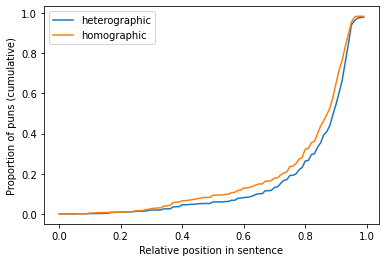

In [54]:
import matplotlib.pyplot as plt

plt.plot([x[0] for x in d], [x[1] for x in d], label='heterographic')
plt.plot([x[0] for x in d2], [x[1] for x in d2], label='homographic')
plt.legend()
plt.xlabel('Relative position in sentence')
plt.ylabel('Proportion of puns (cumulative)')

In [11]:
for ratio in [0.0, 0.5]:
  print(ratio, accuracy_score(gold, bert(puns, gold, ratio)))

100%|██████████| 1607/1607 [04:51<00:00,  5.52it/s]


0.0 0.23397635345364032


100%|██████████| 1607/1607 [04:47<00:00,  5.59it/s]

0.5 0.5003111387678905


In [12]:
for ratio in [0.6, 0.7]:
  print(ratio, accuracy_score(gold, bert(puns, gold, ratio)))

100%|██████████| 1607/1607 [04:41<00:00,  5.70it/s]


0.6 0.5743621655258245


100%|██████████| 1607/1607 [04:40<00:00,  5.73it/s]

0.7 0.6135656502800249


In [13]:
for ratio in [0.8]:
  print(ratio, accuracy_score(gold, bert(puns, gold, ratio)))

100%|██████████| 1607/1607 [04:39<00:00,  5.76it/s]

0.8 0.5998755444928439


In [ ]:
from sklearn.metrics import accuracy_score

for ratio in [0.0, 0.2, 0.4, 0.6, 0.8]:
  print(ratio, accuracy_score(gold, gpt(gold, ratio)))

100%|██████████| 1607/1607 [00:31<00:00, 51.12it/s]


0.0 0.10267579340385811


100%|██████████| 1607/1607 [00:30<00:00, 53.10it/s]


0.2 0.1281891723708774


100%|██████████| 1607/1607 [00:31<00:00, 51.50it/s]


0.4 0.2762912258867455


100%|██████████| 1607/1607 [00:30<00:00, 52.24it/s]


0.6 0.41008089607965154


100%|██████████| 1607/1607 [00:30<00:00, 52.25it/s]

0.8 0.42501555693839455


In [ ]:
print(1.0, accuracy_score(gold, gpt(1.0)))

100%|██████████| 1607/1607 [00:31<00:00, 51.57it/s]

1.0 0.4399502177971375
